## Packages and functions: correct labels, plot images, EDA

In [216]:
import pandas as pd
import numpy as np
import logging
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, confusion_matrix, balanced_accuracy_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, homogeneity_score, completeness_score
from sklearn.feature_selection import SelectFromModel
import threading
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
import warnings
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Filter out specific warning types
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline
np.random.seed(0)
random_state = 42
print_lock = threading.Lock()

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [217]:
def rotateM(x, flip_vertical=False):
    if flip_vertical:
        return np.fliplr(x)
    else:
        return np.transpose(np.apply_along_axis(np.flip, 0, x))

def plot_mislabeled_images(indices, data, label, cmap='gray'):
    plt.figure(figsize=(20, 6))
    for idx, i in enumerate(indices):
        plt.subplot(2, 7, idx + 1)
        plt.imshow(rotateM(data.iloc[i, :].values.reshape(64, 64)), cmap=cmap)
        plt.title(label)
    plt.savefig(f'imgs/data_mislabeled.png')
    plt.show()

def plot_images(data, labels, label_names, key_='init', cmap='gray'):
    labels = labels.values.reshape(-1)
    num_rows = 18
    num_cols = 11
    plt.figure(figsize=(30, 30))
    for i in range(num_rows):
        for j in range(num_cols):
            idx = i * num_cols + j
            animal = label_names[labels[idx]]
            plt.subplot(18, 11, idx + 1)
            plt.imshow(rotateM(data.iloc[idx, :].values.reshape(64, 64)), cmap=cmap)
            plt.title(animal)
    plt.tight_layout()
    plt.savefig(f'imgs/{key_}/data.png')
    plt.show()

def correct_labels(data, true_dogs, true_cats):
    ''' 0 for cats and 1 for dogs'''
    for d in true_dogs:
        data.values[d] = 1
    for c in true_cats:
        data.values[c] = 0
    return data

ssc_mislabeled = [26, 54, 114, 117]
ssd_mislabeled = [8, 37, 112, 151, 176, 177]

In [218]:
def mean_animal(x, y):
    cat_indices = np.where(y == 0)[0]  
    dog_indices = np.where(y == 1)[0] 

    mean_cat = np.mean(x.iloc[cat_indices], axis=0)
    mean_dog = np.mean(x.iloc[dog_indices], axis=0)

    mean_cat_image = rotateM(mean_cat.values.reshape(64, 64))
    mean_dog_image = rotateM(mean_dog.values.reshape(64, 64))

    return mean_cat_image,  mean_dog_image

def plot_mean_images(x, y):
    ''' Mean Cat and Dog. '''
    mean_cat_image,  mean_dog_image = mean_animal(x, y)

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.imshow(mean_cat_image, cmap='gray')
    plt.title('Mean Cat Image')
    plt.subplot(2, 2, 2)
    plt.imshow(mean_dog_image, cmap='gray')
    plt.title('Mean Dog Image')
    plt.savefig(f'imgs/mean_animal.png')
    plt.show()

In [219]:
def print_label_counts(y):
    num_cats = np.count_nonzero(y == 0)
    num_dogs = np.count_nonzero(y == 1)
    print("Number of cats:", num_cats)
    print("Number of dogs:", num_dogs)

## Models and functions: constants, objects, training and analysis

### Hyper-parameters

In [220]:
# Random Forest
n_estimators = [15, 50, 100, 150, 250]
max_depth = [None, 3, 5, 10]

# Logistic Regression
penalty = ['l2']
C = [0.01, 0.1, 1, 10]

# KNN
n_neighbors = [3, 5, 7, 10]
cluster_nums = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# SVM
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
C = [0.01, 0.1, 1, 10]

# MLP
hidden_layer_sizes = [(100,), (100, 50), (100, 75, 50), (200, ), (200, 100), (200, 150, 100)]

### Constants and objects

In [221]:
# Preprocessing
variance_threshold = VarianceThreshold()
scaler = StandardScaler()

# labels
label_names = ['Cat', 'Dog']

# Scoring
scoring = 'accuracy'

# Models meta data dictionary for grid search
model_map = { 
  'rf': {
    'model': RandomForestClassifier(random_state=random_state, n_jobs=-1),
    'params': {
      'rf__n_estimators': n_estimators,
      'rf__max_depth': max_depth,
    },
    'name': 'Random Forest'
  },
  
  'lr': {
    'model': LogisticRegression(random_state=random_state, n_jobs=-1, solver='lbfgs', max_iter=1000),
    'params': {
      'lr__penalty': penalty,
      'lr__C': C,
    },
    'name': 'Logistic Regression'
  },
  
  'knn': {
    'model': KNeighborsClassifier(n_jobs=-1),
    'params': {
      'knn__n_neighbors': n_neighbors,
    },
    'name': 'K-Nearest Neighbors'
  },
  
  'svm': {
    'model': SVC(random_state=random_state),
    'params': {
      'svm__kernel': kernel,
      'svm__C': C,
    },
    'name': 'Support Vector Machine'
  },
  
  'mlp': {
    'model': MLPClassifier(random_state=random_state, early_stopping=True),
    'params': {
      'mlp__hidden_layer_sizes': hidden_layer_sizes,
    }, 
    'name': 'Multi-Layer Perceptron'
  },
}

### Functions: splits, grid search, classification report

In [222]:
def splits(X, Y, test_size=0.2, validation_set=False, validation_size=0.2):
    ''' Split into train and test. Validation size is the percentage of train data that will be validation data. '''
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    
    if validation_set:
        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=validation_size, random_state=random_state, stratify=Y_train)
        return X_train, X_val, X_test, Y_train, Y_val, Y_test
    
    return X_train, X_test, Y_train, Y_test

In [223]:
def run_grid_search(X_train, Y_train, model_key, model_info, scoring='accuracy', cv=3):
    best_params = {}
    best_cv_scores = {}
    best_models = {}
    
    model = model_info['model']
    params = model_info['params']
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        (model_key, model)
    ])

    # Perform grid search
    grid_search_res = GridSearchCV(pipeline, params, scoring=scoring, cv=cv, n_jobs=-1)
    grid_search_res.fit(X_train, np.ravel(Y_train))
    
    # Save best parameters and score
    best_params['model'] = grid_search_res.best_params_
    best_cv_scores['model'] = grid_search_res.best_score_
    best_models['model'] = grid_search_res.best_estimator_        
    
    return grid_search_res

In [224]:
def plot_confusion_matrix(Y_test, Y_pred, labels, model_name, key, flag_plot):
  # confusion matrix and display
  cm = confusion_matrix(Y_test, Y_pred)
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  
  # plot the confusion matrix
  cm_display.plot()
  plt.title(f'Confusion matrix for test data (model: {model_name})')
  plt.savefig(f'imgs/{key}/CM_{model_name}.png')
  if flag_plot:
    plt.show()
  
def show_classification_report(Y_test, Y_pred, model_name: str, key):
  print(f"Classification Report for test data (key: {key}, model: {model_name}) \n {classification_report(Y_test, Y_pred, target_names=label_names)}")

def plot_roc_curve(Y_test, Y_pred, model_name, key, flag_plot):
  fpr, tpr, _ = roc_curve(Y_test, Y_pred)
  roc_auc = auc(fpr, tpr)  # Calculate AUC score
  
  plt.plot(fpr, tpr, color='orange', label=f'ROC (AUC = {roc_auc:.2f})')  # Add AUC score to the label
  plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve for {model_name} (test data)')
  plt.legend()
  plt.savefig(f'imgs/{key}/ROC_{model_name}.png')
  if flag_plot:
    plt.show()

### Functions: part 1

In [225]:
def plot_feature_importance(results, X, Y, key, dim, n_best=500):
    feat_importance_lr = []
    feat_importance_rf = []
    feat_importance_anova = []
    
    for model_key, model_info in results.items():
        # random forest case
        if model_key == 'rf':
            model = model_info['grid_search_res'].best_estimator_
            feat_importance_rf.append(model.named_steps[model_key].feature_importances_)
        # logistic regression case
        if model_key == 'lr':
            model = model_info['grid_search_res'].best_estimator_
            feat_importance_lr.append(np.abs(model.named_steps[model_key].coef_))
            
    # compute feature importance with anova test
    anova = SelectKBest(score_func=f_classif, k='all')
    anova.fit(X, Y.values.ravel())
    
    # Ensure feature importance arrays are flattened and have the correct length
    feat_importance_lr = np.array(feat_importance_lr).flatten()
    feat_importance_rf = np.array(feat_importance_rf).flatten()
    feat_importance_anova = np.array(anova.scores_)
    
    # Function to get top n features and pad the rest with zeros
    def get_top_n_features(importance, n):
        top_indices = np.argsort(importance)[-n:]
        top_importance = np.zeros_like(importance)
        top_importance[top_indices] = importance[top_indices]
        return top_importance
    
    # Get the top n features for each method
    feat_importance_lr = get_top_n_features(feat_importance_lr, n_best)
    feat_importance_rf = get_top_n_features(feat_importance_rf, n_best)
    feat_importance_anova = get_top_n_features(feat_importance_anova, n_best)
        
    # Reshape a test image
    sample_image = rotateM(X.iloc[100, :].values.reshape(dim, dim))

    # Compute the coordinates for each pixel
    coordinates = [(i, j) for i in range(dim) for j in range(dim)]
    x, y = zip(*coordinates)
    
    # Function to plot feature importances
    def plot_importance(ax, image, importance, title):
        ax.imshow(image, cmap='gray')   
        scatter = ax.scatter(x, y, c=importance, cmap='hot', s=10)
        plt.colorbar(scatter, ax=ax)
        ax.set_title(title)

    # Create subplots
    _, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot feature importances
    plot_importance(axes[0], sample_image, feat_importance_rf, 'Random Forest Feature Importance')
    plot_importance(axes[1], sample_image, feat_importance_lr, 'Logistic Regression Feature Importance')
    plot_importance(axes[2], sample_image, feat_importance_anova, 'ANOVA Feature Importance')
    
    plt.tight_layout()
    plt.savefig(f'imgs/{key}/Feature_importance.png')
    plt.show()

In [226]:
def clustering(X_train, X_test, Y_train, Y_test, cluster_numbers=cluster_nums):
    results = []

    for n_clusters in cluster_numbers:
        kmeans = KMeans(n_clusters=n_clusters)
        cluster_labels_train = kmeans.fit_predict(X_train)
        cluster_labels_test = kmeans.predict(X_test)

        # Compute homogeneity and completeness for training data
        homogeneity_train = homogeneity_score(Y_train, cluster_labels_train)
        completeness_train = completeness_score(Y_train, cluster_labels_train)
        accuracy_score_train = accuracy_score(Y_train, cluster_labels_train)
        
        # Compute homogeneity and completeness for test data
        homogeneity_test = homogeneity_score(Y_test, cluster_labels_test)
        completeness_test = completeness_score(Y_test, cluster_labels_test)
        accuracy_score_test = accuracy_score(Y_test, cluster_labels_test)
        
        # Align cluster labels with class labels for training data
        aligned_labels_train = np.zeros_like(cluster_labels_train)
        for cluster in range(n_clusters):
            mask = (cluster_labels_train == cluster)
            majority_class = np.bincount(Y_train[mask]).argmax() if np.sum(mask) > 0 else -1  # Majority class in the cluster
            aligned_labels_train[mask] = majority_class
        
        # Recalculate homogeneity and completeness after alignment for training data
        aligned_homogeneity_train = homogeneity_score(Y_train, aligned_labels_train)
        aligned_completeness_train = completeness_score(Y_train, aligned_labels_train)
        accuracy_score_train_aligned = accuracy_score(Y_train, aligned_labels_train)
        
        # Align cluster labels with class labels for test data
        aligned_labels_test = np.zeros_like(cluster_labels_test)
        for cluster in range(n_clusters):
            mask = (cluster_labels_test == cluster)
            majority_class = np.bincount(Y_test[mask]).argmax() if np.sum(mask) > 0 else -1  # Majority class in the cluster
            aligned_labels_test[mask] = majority_class

        # Recalculate homogeneity and completeness after alignment for test data
        aligned_homogeneity_test = homogeneity_score(Y_test, aligned_labels_test)
        aligned_completeness_test = completeness_score(Y_test, aligned_labels_test)
        accuracy_score_test_aligned = accuracy_score(Y_test, aligned_labels_test)
        
        results.append({
            # "Cluster Number": n_clusters,
            # "Train Homogeneity": homogeneity_train,
            # "Train Completeness": completeness_train,
            # "Train Aligned Homogeneity": aligned_homogeneity_train,
            # "Train Aligned Completeness": aligned_completeness_train,
            # "Test Homogeneity": homogeneity_test,
            # "Test Completeness": completeness_test,
            # "Test Aligned Homogeneity": aligned_homogeneity_test,
            # "Test Aligned Completeness": aligned_completeness_test
            "Train Accuracy": accuracy_score_train,
            "Train Aligned Accuracy": accuracy_score_train_aligned,
            "Test Accuracy": accuracy_score_test,
            "Test Aligned Accuracy": accuracy_score_test_aligned
        })
    
    return results

### Functions: part 2

In [227]:
def plot_sample_image_with_grid(data, image_index=1):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(rotateM(data.iloc[image_index, :].values.reshape(64, 64)), cmap='gray')
    plt.title('Random Image')
    plt.subplot(1, 2, 2)
    plt.imshow(rotateM(data.iloc[image_index, :].values.reshape(64, 64)), cmap='gray')
    plt.title('Random Image with Grid')
    for i in range(1, 4):
        plt.axhline(i * 16, color='r', linestyle='--')
        plt.axvline(i * 16, color='r', linestyle='--')
        for row in range(4):
            for col in range(4):
                plt.text(col * 16 + 3, row * 16 + 3, str(row * 4 + col), color='r')
    plt.show()

def blocks_datasets(dataset):
    """ 16 datasets, each representing a block. """
    blocks = []  
    for row in range(4): 
        for col in range(4):  
            # pixel/feature indices corresponding to the block
            block_indices = [] 
            for i in range(64):  
                for j in range(64): 
                    # add the pixel belongs to the current block
                    if (i // 16 == row) and (j // 16 == col):
                        # calculate index of the pixel
                        block_indices.append(i * 64 + j) 
            blocks.append(dataset[:, block_indices])
    return blocks

# plot image and block 
def plot_blocks(dataset, block_dataset):
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 3, 1)
    plt.imshow(rotateM(dataset.iloc[3, :].values.reshape(64, 64)), cmap='gray')
    # define picture
    img = 3
    c = 2
    for i in [1, 2, 3, 4, 5, 6]:
        plt.subplot(2, 3, c)
        plt.imshow(rotateM(block_dataset[i][img].reshape(16, 16)), cmap='gray')
        c = c + 1
    plt.show()

def flip_half_images_upside_down(X, Y):
    ''' Flip half of the images (reorder columns for half of the dataset).'''
    # cats and dogs random selection
    cat_indices = np.where(Y == 0)[0]
    dog_indices = np.where(Y == 1)[0]
    np.random.shuffle(cat_indices)
    np.random.shuffle(dog_indices)
    # 44 cats and 45 dogs
    cat_indices_to_flip = cat_indices[:44]
    dog_indices_to_flip = dog_indices[:45]

    X_flipped = X.copy()
    # flatten result of flipped images
    for idx in cat_indices_to_flip:
        X_flipped.iloc[idx] = rotateM(X_flipped.iloc[idx].values.reshape(64, 64), flip_vertical=True).flatten()

    for idx in dog_indices_to_flip:
        X_flipped.iloc[idx] = rotateM(X_flipped.iloc[idx].values.reshape(64, 64), flip_vertical=True).flatten()
        
    return X_flipped
    

## Main processes

In [228]:
def process_model(model_key, model_info, X_train, X_test, Y_train, Y_test, key, scoring='accuracy'):
    ''' Best parameters for a given algorithm. '''
    # grid search to get best model/parameters for given algorithm
    grid_search_res = run_grid_search(X_train, Y_train, model_key, model_info)
    Y_test_pred = grid_search_res.predict(X_test)
    
    # metrics on the test data
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    test_f1_score = f1_score(Y_test, Y_test_pred, average='macro')
    test_roc_auc_score = roc_auc_score(Y_test, Y_test_pred)
        
    # prepare log messages
    log_messages = [
        f'Experiment: {key}\n'
        f"Best parameters found for {model_info['name']}: {grid_search_res.best_params_}",
        f"Best CV {scoring} score: {grid_search_res.best_score_}",
        f'Model: {model_info["name"]}, test accuracy score: {test_accuracy}, test f1 Score: {test_f1_score}',
    ]

    # return info
    return {
        'model_key': model_key,
        'model_name': model_info["name"], 
        'grid_search_res': grid_search_res, 
        'test_accuracy': test_accuracy, 
        'test_f1_score': test_f1_score,
        'test_roc_auc_score': test_roc_auc_score,
        'Y_test_pred': Y_test_pred,
        'log_messages': log_messages,
    }



def show_results_summary(results, key='init'):
    # Print results summary in a tabular format (using pandas DataFrame)
    results_summary = []
    for _, result in results.items():
        results_summary.append({
            'Model': result['model_name'],
            'CV accuracy': result['grid_search_res'].best_score_,
            'Test Accuracy': result['test_accuracy'],
            'Test f1 score': result['test_f1_score'],
            'Test ROC AUC score': result['test_roc_auc_score'],
        })
        
    results_df = pd.DataFrame(results_summary)
    display(results_df)

In [229]:
def main_parallel(model_map, X, Y, key, flag_plot=True):
    results = {} # keys are model keys and values are results dictionaries
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # split dataset
        X_train, X_test, Y_train, Y_test = splits(X, Y)
        
        futures = {}
        for model_key, model_info in model_map.items():
            future = executor.submit(process_model, model_key, model_info, X_train, X_test, Y_train, Y_test, key)
            futures[future] = model_key
        
        for future in concurrent.futures.as_completed(futures):
            model_key = futures[future]
            result = future.result()
            results[model_key] = result
                
        # print results summary
        if key == 'init':
            with print_lock:
                print('\n\n**************************************************')
                print('**RESULTS SUMMARY**\n')
                show_results_summary(results)
                print('**************************************************\n\n')
                
        # print results for each model
        for _, result in results.items():
            # log results
            with print_lock:
                
                print('--------------------------------------------------')
                for message in result['log_messages']:
                    print(message)
                plot_confusion_matrix(Y_test, result['Y_test_pred'], label_names, result['model_name'], key, flag_plot)
                plot_roc_curve(Y_test, result['Y_test_pred'], result['model_name'], key, flag_plot)
                show_classification_report(Y_test, result['Y_test_pred'], result['model_name'], key)
                print('--------------------------------------------------\n\n')
    
    return results

In [230]:
def get_results_blocks(model_map, X, Y, key, flag=False, flag_plot=True):
    X_cats_dogs_blocks = blocks_datasets(X.values)
    if flag:
        plot_blocks(X, X_cats_dogs_blocks)
    
    results_blocks = []

    for index, X_block in enumerate(X_cats_dogs_blocks):
        results = {}
        results['block'] = X_block
        results['results'] = main_parallel(model_map, X_block, Y, f"block_{index}", flag_plot)  
        results_blocks.append(results)

    return results_blocks

## Read data and work on it

In [231]:
# read cats and dogs data
X_cats_dogs = pd.read_csv('../data/CATSnDOGS.csv')
Y_cats_dogs = pd.read_csv('../data/CATSnDOGSlabels.csv')

X_cats_dogs_flipped = pd.DataFrame(flip_half_images_upside_down(X_cats_dogs, Y_cats_dogs))
Y_cats_dogs = correct_labels(Y_cats_dogs, true_dogs = [26, 54, 114, 117], true_cats = [8, 37, 112, 151, 176, 177])

#plot_mislabeled_images(ssc_mislabeled, X_cats_dogs, label="cat") 
#plot_images(X_cats_dogs, Y_cats_dogs, {0: "cat", 1: "dog"}, key_='init')
#plot_mean_images(X_cats_dogs, Y_cats_dogs)
#print_label_counts(Y_cats_dogs)

### 1.a Comparison of classifiers



**************************************************
**RESULTS SUMMARY**



Model  CV accuracy  Test Accuracy  Test f1 score  \
0     K-Nearest Neighbors     0.797412          0.800       0.791667   
1  Support Vector Machine     0.898645          0.875       0.871051   
2     Logistic Regression     0.873488          0.825       0.822222   
3  Multi-Layer Perceptron     0.854015          0.800       0.795396   
4           Random Forest     0.797533          0.850       0.843750   

   Test ROC AUC score  
0            0.800000  
1            0.886667  
2            0.846667  
3            0.813333  
4            0.853333

**************************************************


--------------------------------------------------
Experiment: init
Best parameters found for K-Nearest Neighbors: {'knn__n_neighbors': 3}
Best CV accuracy score: 0.7974117077890662
Model: K-Nearest Neighbors, test accuracy score: 0.8, test f1 Score: 0.7916666666666667


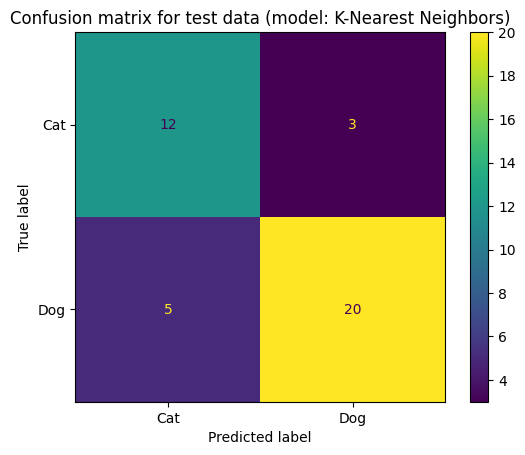

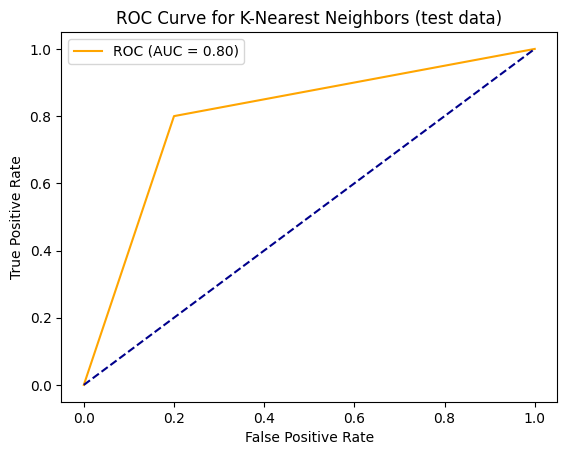

Classification Report for test data (key: init, model: K-Nearest Neighbors) 
               precision    recall  f1-score   support

         Cat       0.71      0.80      0.75        15
         Dog       0.87      0.80      0.83        25

    accuracy                           0.80        40
   macro avg       0.79      0.80      0.79        40
weighted avg       0.81      0.80      0.80        40

--------------------------------------------------


--------------------------------------------------
Experiment: init
Best parameters found for Support Vector Machine: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best CV accuracy score: 0.8986453797774553
Model: Support Vector Machine, test accuracy score: 0.875, test f1 Score: 0.871050934880722


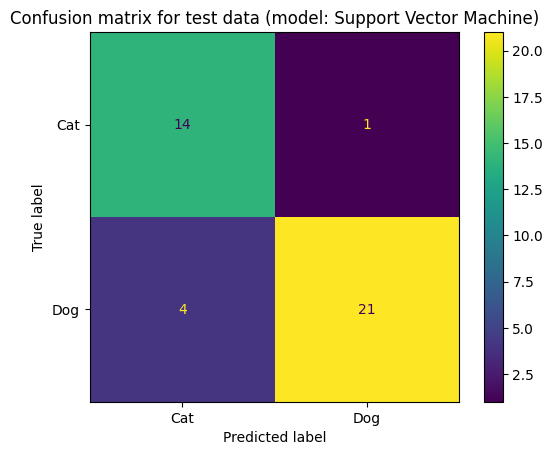

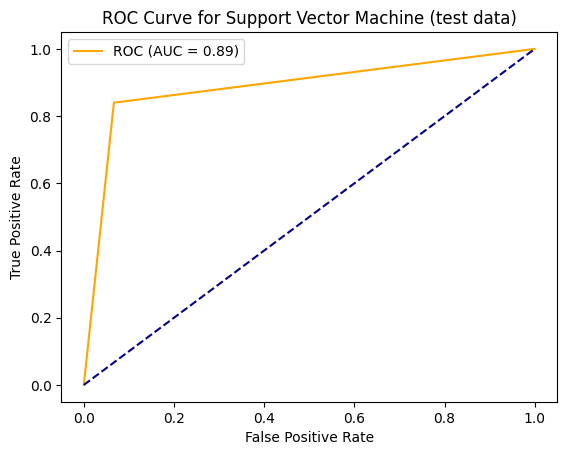

Classification Report for test data (key: init, model: Support Vector Machine) 
               precision    recall  f1-score   support

         Cat       0.78      0.93      0.85        15
         Dog       0.95      0.84      0.89        25

    accuracy                           0.88        40
   macro avg       0.87      0.89      0.87        40
weighted avg       0.89      0.88      0.88        40

--------------------------------------------------


--------------------------------------------------
Experiment: init
Best parameters found for Logistic Regression: {'lr__C': 0.1, 'lr__penalty': 'l2'}
Best CV accuracy score: 0.8734881470730528
Model: Logistic Regression, test accuracy score: 0.825, test f1 Score: 0.8222222222222222


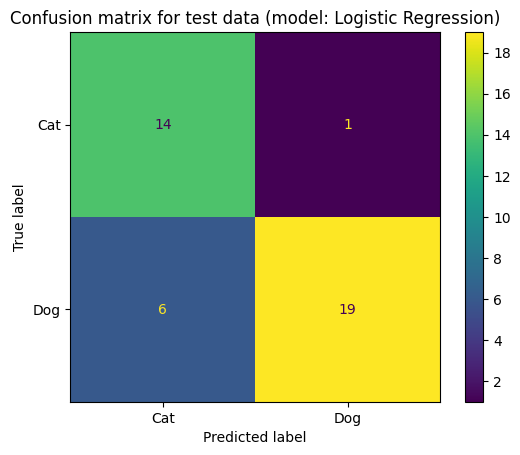

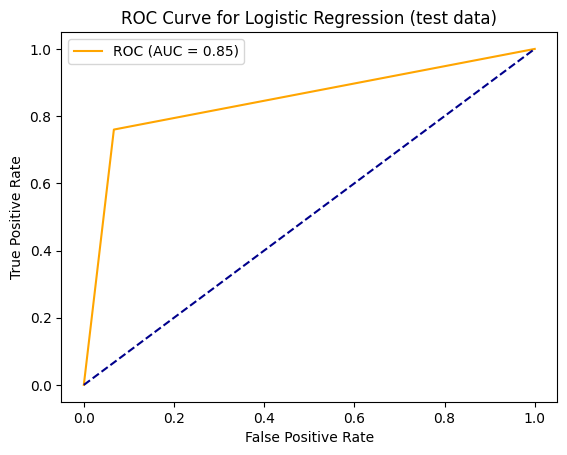

Classification Report for test data (key: init, model: Logistic Regression) 
               precision    recall  f1-score   support

         Cat       0.70      0.93      0.80        15
         Dog       0.95      0.76      0.84        25

    accuracy                           0.82        40
   macro avg       0.82      0.85      0.82        40
weighted avg       0.86      0.82      0.83        40

--------------------------------------------------


--------------------------------------------------
Experiment: init
Best parameters found for Multi-Layer Perceptron: {'mlp__hidden_layer_sizes': (200, 150, 100)}
Best CV accuracy score: 0.8540154813739719
Model: Multi-Layer Perceptron, test accuracy score: 0.8, test f1 Score: 0.7953964194373402


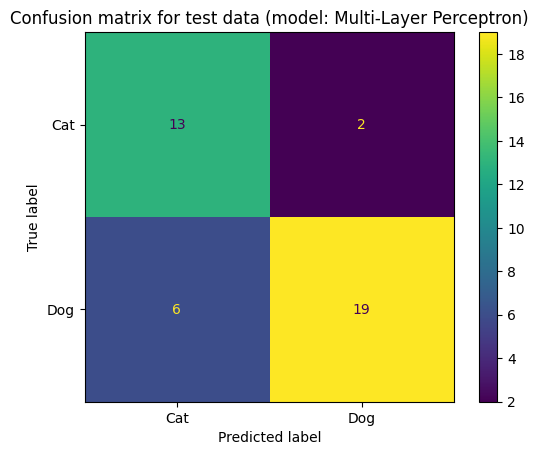

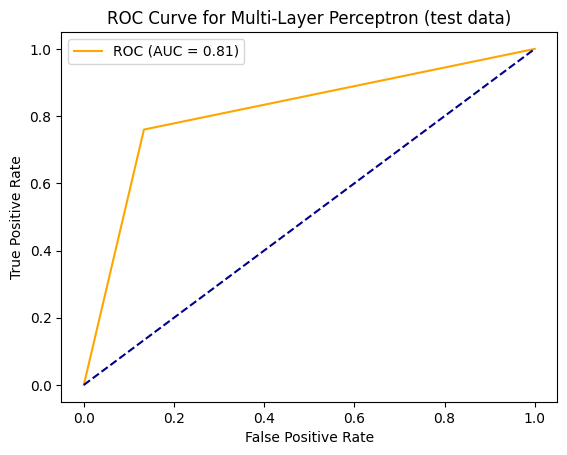

Classification Report for test data (key: init, model: Multi-Layer Perceptron) 
               precision    recall  f1-score   support

         Cat       0.68      0.87      0.76        15
         Dog       0.90      0.76      0.83        25

    accuracy                           0.80        40
   macro avg       0.79      0.81      0.80        40
weighted avg       0.82      0.80      0.80        40

--------------------------------------------------


--------------------------------------------------
Experiment: init
Best parameters found for Random Forest: {'rf__max_depth': None, 'rf__n_estimators': 150}
Best CV accuracy score: 0.7975326560232222
Model: Random Forest, test accuracy score: 0.85, test f1 Score: 0.84375


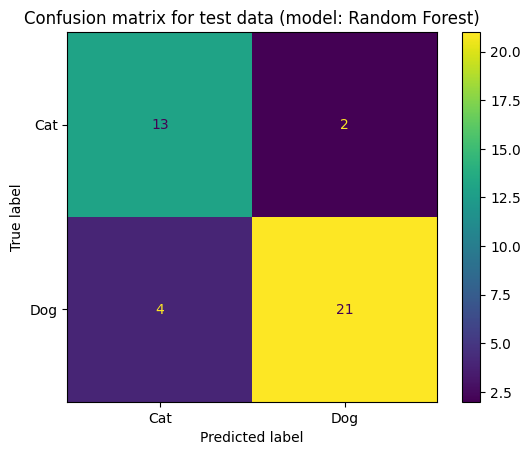

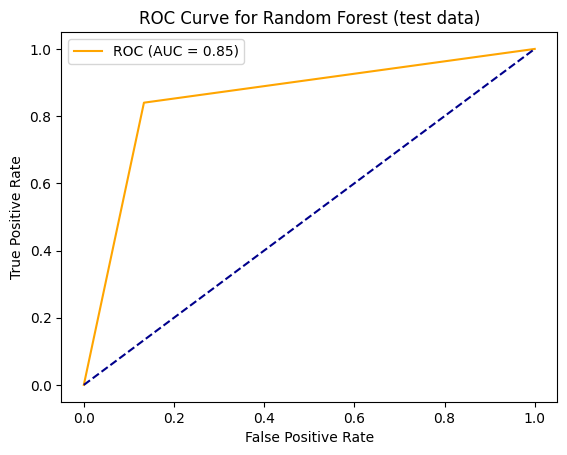

Classification Report for test data (key: init, model: Random Forest) 
               precision    recall  f1-score   support

         Cat       0.76      0.87      0.81        15
         Dog       0.91      0.84      0.88        25

    accuracy                           0.85        40
   macro avg       0.84      0.85      0.84        40
weighted avg       0.86      0.85      0.85        40

--------------------------------------------------




In [232]:
results = main_parallel(model_map, X_cats_dogs, Y_cats_dogs, key='init', flag_plot=True)

### 1.b Feature importance methods

In [233]:
#plot_feature_importance(results, X_cats_dogs, Y_cats_dogs, key='init', dim=64)

### 1.c Clustering

In [234]:
#X_train, X_test, Y_train, Y_test = splits(X_cats_dogs, Y_cats_dogs)
#clustering(X_train, X_test, np.ravel(Y_train), np.ravel(Y_test), cluster_numbers = cluster_nums)

### 2.b Results for blocks

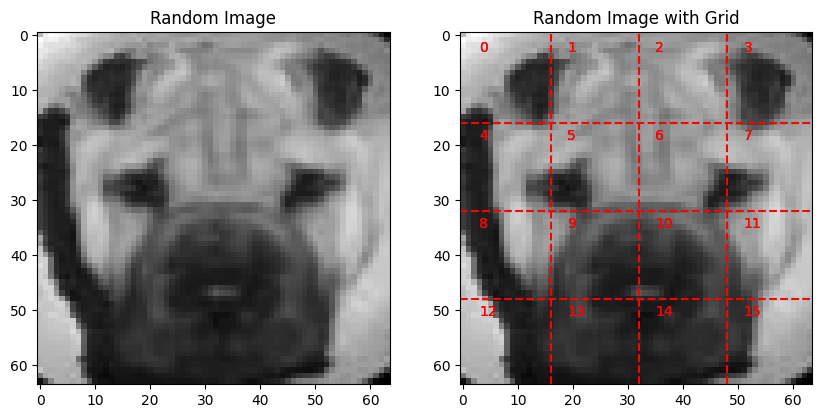

In [239]:
plot_sample_image_with_grid(X_cats_dogs, image_index=4)

--------------------------------------------------
Experiment: block_0
Best parameters found for K-Nearest Neighbors: {'knn__n_neighbors': 5}
Best CV accuracy score: 0.7402031930333818
Model: K-Nearest Neighbors, test accuracy score: 0.75, test f1 Score: 0.7252747252747254


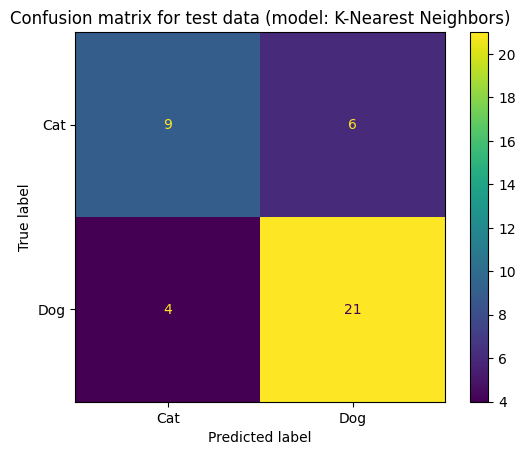

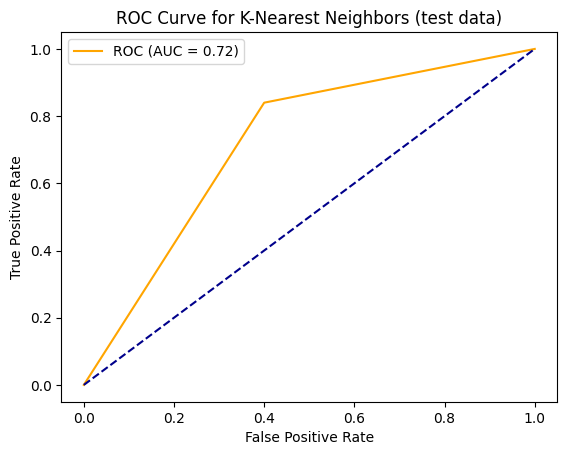

Classification Report for test data (key: block_0, model: K-Nearest Neighbors) 
               precision    recall  f1-score   support

         Cat       0.69      0.60      0.64        15
         Dog       0.78      0.84      0.81        25

    accuracy                           0.75        40
   macro avg       0.74      0.72      0.73        40
weighted avg       0.75      0.75      0.75        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_0
Best parameters found for Support Vector Machine: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best CV accuracy score: 0.8033381712626996
Model: Support Vector Machine, test accuracy score: 0.75, test f1 Score: 0.7333333333333334


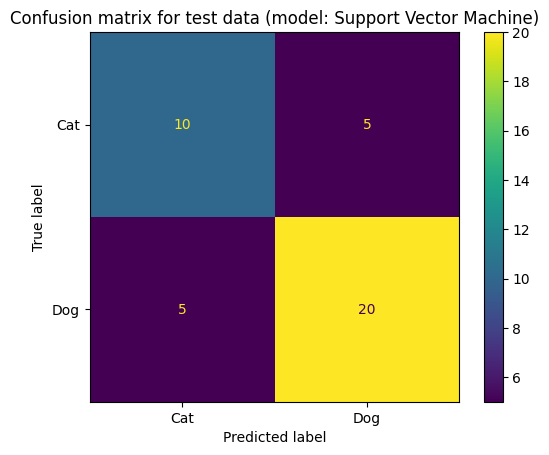

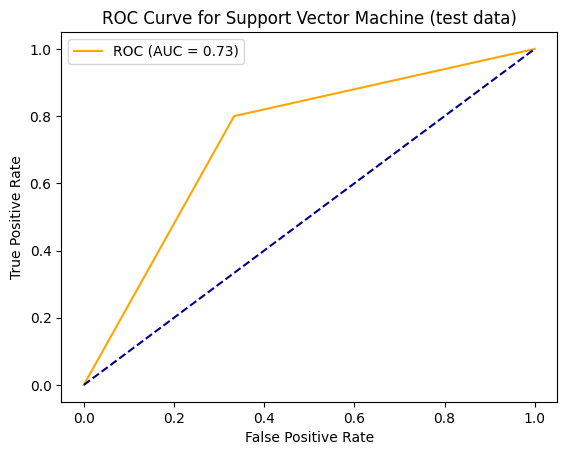

Classification Report for test data (key: block_0, model: Support Vector Machine) 
               precision    recall  f1-score   support

         Cat       0.67      0.67      0.67        15
         Dog       0.80      0.80      0.80        25

    accuracy                           0.75        40
   macro avg       0.73      0.73      0.73        40
weighted avg       0.75      0.75      0.75        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_0
Best parameters found for Multi-Layer Perceptron: {'mlp__hidden_layer_sizes': (200, 150, 100)}
Best CV accuracy score: 0.8037010159651669
Model: Multi-Layer Perceptron, test accuracy score: 0.8, test f1 Score: 0.7720797720797721


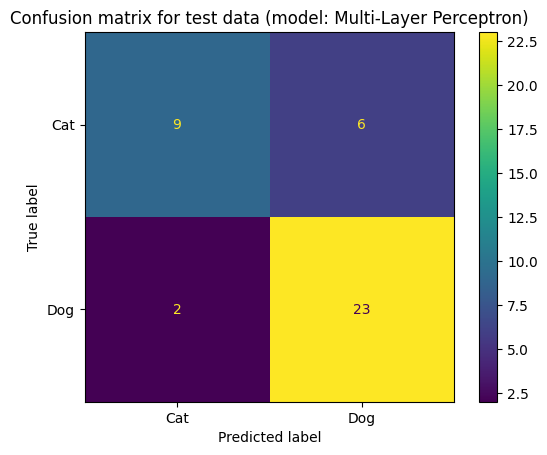

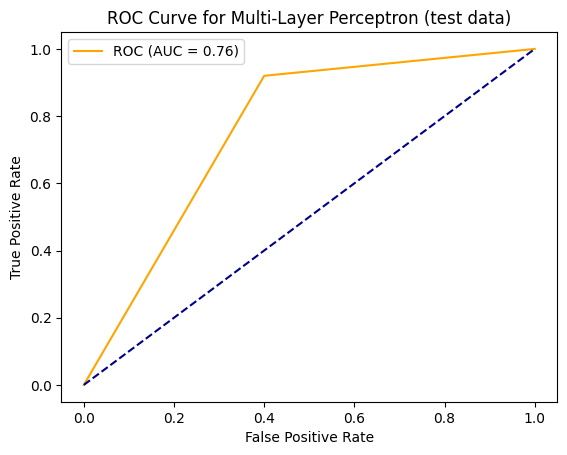

Classification Report for test data (key: block_0, model: Multi-Layer Perceptron) 
               precision    recall  f1-score   support

         Cat       0.82      0.60      0.69        15
         Dog       0.79      0.92      0.85        25

    accuracy                           0.80        40
   macro avg       0.81      0.76      0.77        40
weighted avg       0.80      0.80      0.79        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_0
Best parameters found for Logistic Regression: {'lr__C': 0.1, 'lr__penalty': 'l2'}
Best CV accuracy score: 0.7087566521528785
Model: Logistic Regression, test accuracy score: 0.625, test f1 Score: 0.6190476190476191


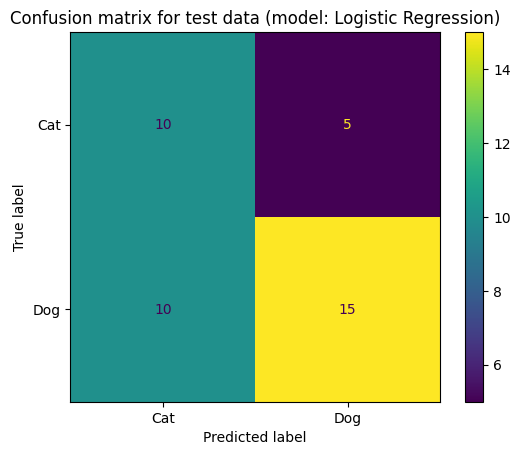

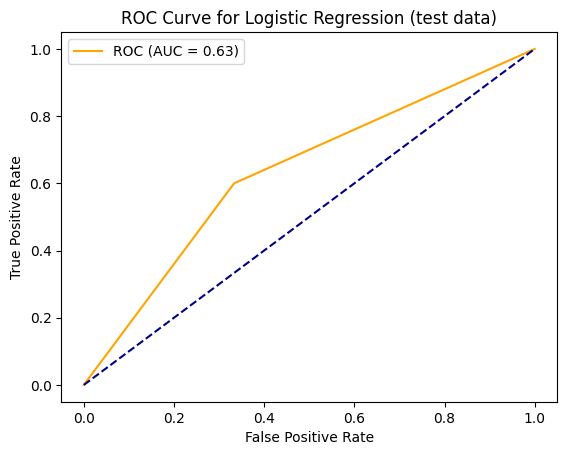

Classification Report for test data (key: block_0, model: Logistic Regression) 
               precision    recall  f1-score   support

         Cat       0.50      0.67      0.57        15
         Dog       0.75      0.60      0.67        25

    accuracy                           0.62        40
   macro avg       0.62      0.63      0.62        40
weighted avg       0.66      0.62      0.63        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_0
Best parameters found for Random Forest: {'rf__max_depth': None, 'rf__n_estimators': 100}
Best CV accuracy score: 0.8162796323173681
Model: Random Forest, test accuracy score: 0.825, test f1 Score: 0.8043326345213138


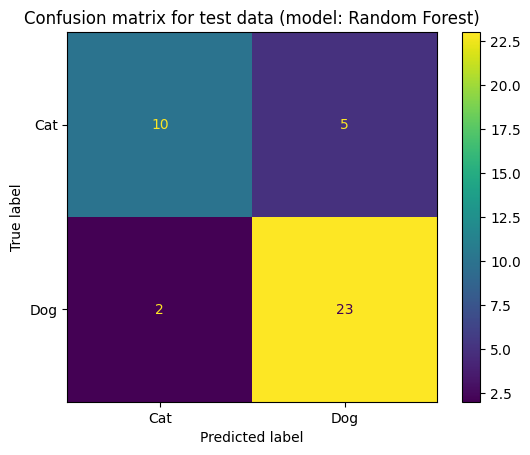

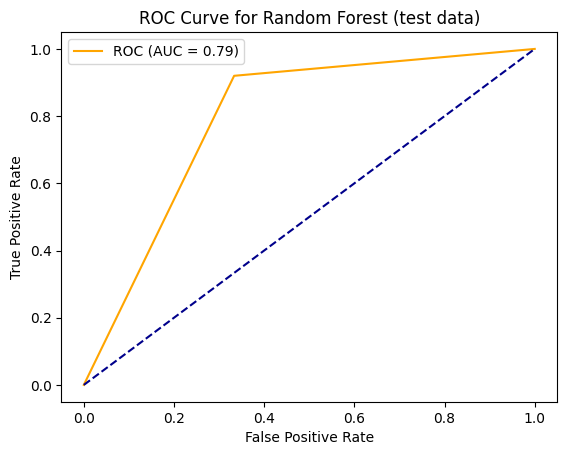

Classification Report for test data (key: block_0, model: Random Forest) 
               precision    recall  f1-score   support

         Cat       0.83      0.67      0.74        15
         Dog       0.82      0.92      0.87        25

    accuracy                           0.82        40
   macro avg       0.83      0.79      0.80        40
weighted avg       0.83      0.82      0.82        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_1
Best parameters found for K-Nearest Neighbors: {'knn__n_neighbors': 3}
Best CV accuracy score: 0.5885341074020319
Model: K-Nearest Neighbors, test accuracy score: 0.575, test f1 Score: 0.5402298850574713


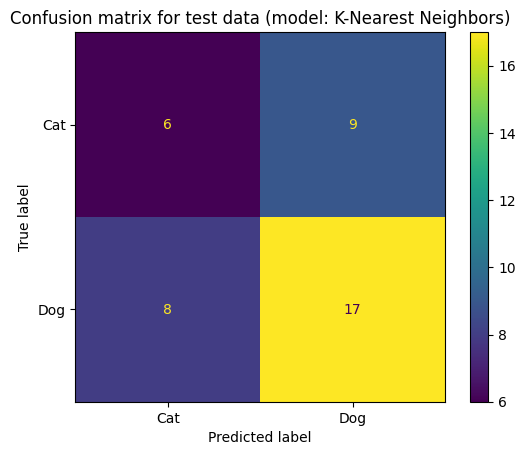

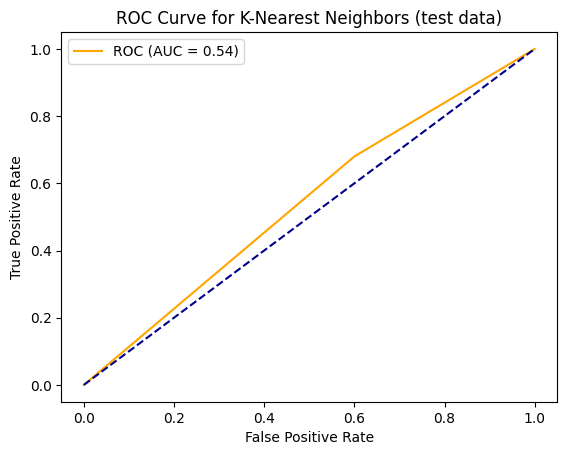

Classification Report for test data (key: block_1, model: K-Nearest Neighbors) 
               precision    recall  f1-score   support

         Cat       0.43      0.40      0.41        15
         Dog       0.65      0.68      0.67        25

    accuracy                           0.57        40
   macro avg       0.54      0.54      0.54        40
weighted avg       0.57      0.57      0.57        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_1
Best parameters found for Logistic Regression: {'lr__C': 10, 'lr__penalty': 'l2'}
Best CV accuracy score: 0.6771891630382196
Model: Logistic Regression, test accuracy score: 0.675, test f1 Score: 0.6218181818181818


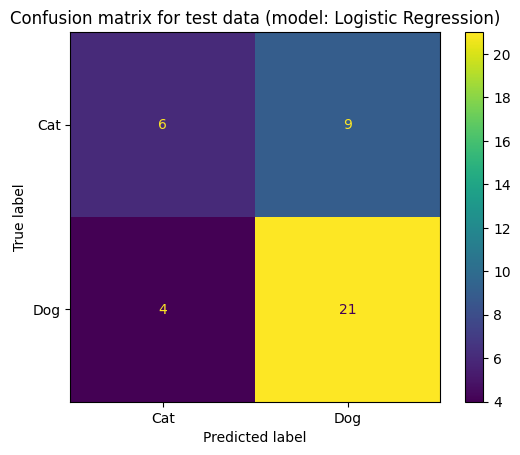

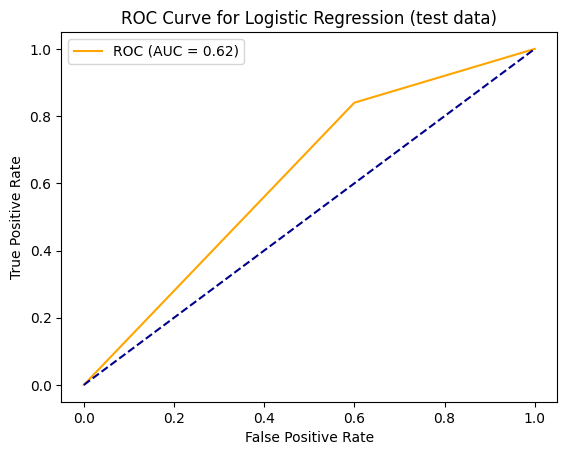

Classification Report for test data (key: block_1, model: Logistic Regression) 
               precision    recall  f1-score   support

         Cat       0.60      0.40      0.48        15
         Dog       0.70      0.84      0.76        25

    accuracy                           0.68        40
   macro avg       0.65      0.62      0.62        40
weighted avg       0.66      0.68      0.66        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_1
Best parameters found for Support Vector Machine: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best CV accuracy score: 0.7022254475084663
Model: Support Vector Machine, test accuracy score: 0.725, test f1 Score: 0.6925227113906359


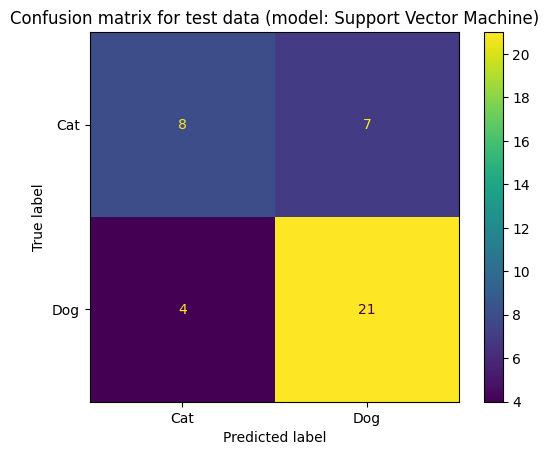

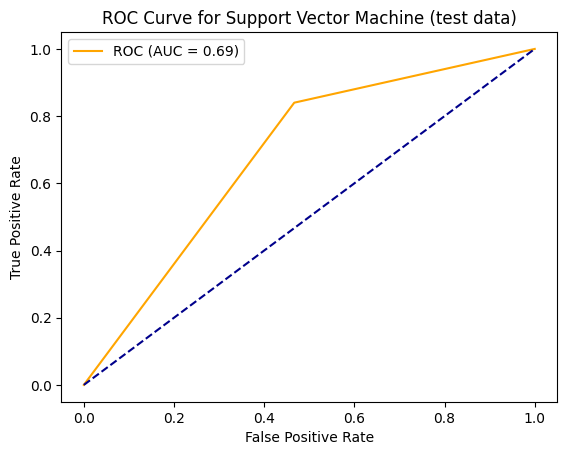

Classification Report for test data (key: block_1, model: Support Vector Machine) 
               precision    recall  f1-score   support

         Cat       0.67      0.53      0.59        15
         Dog       0.75      0.84      0.79        25

    accuracy                           0.72        40
   macro avg       0.71      0.69      0.69        40
weighted avg       0.72      0.72      0.72        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_1
Best parameters found for Multi-Layer Perceptron: {'mlp__hidden_layer_sizes': (200, 150, 100)}
Best CV accuracy score: 0.6456216739235607
Model: Multi-Layer Perceptron, test accuracy score: 0.7, test f1 Score: 0.6799999999999999


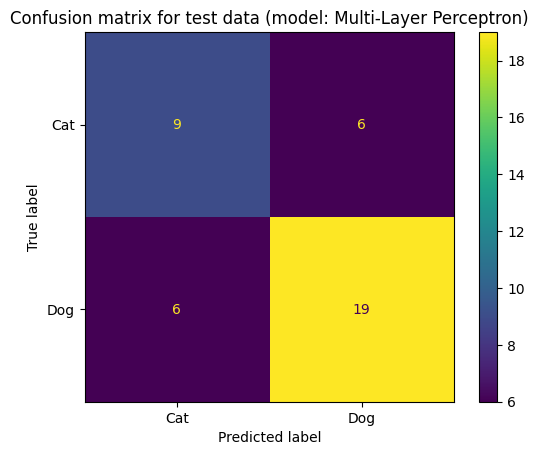

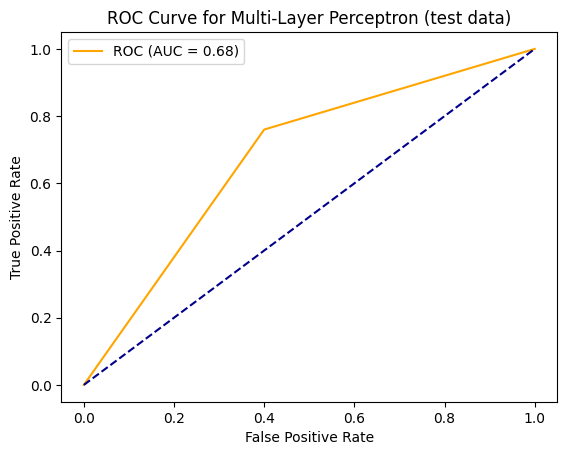

Classification Report for test data (key: block_1, model: Multi-Layer Perceptron) 
               precision    recall  f1-score   support

         Cat       0.60      0.60      0.60        15
         Dog       0.76      0.76      0.76        25

    accuracy                           0.70        40
   macro avg       0.68      0.68      0.68        40
weighted avg       0.70      0.70      0.70        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_1
Best parameters found for Random Forest: {'rf__max_depth': None, 'rf__n_estimators': 150}
Best CV accuracy score: 0.6201015965166908
Model: Random Forest, test accuracy score: 0.675, test f1 Score: 0.6576695194206715


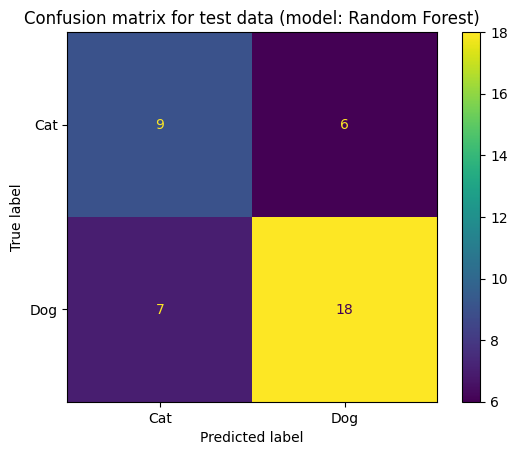

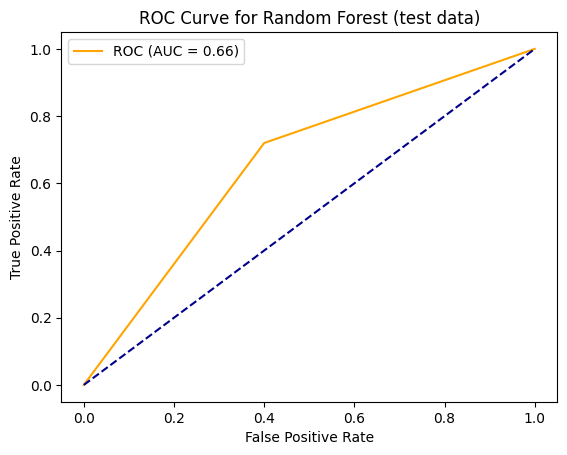

Classification Report for test data (key: block_1, model: Random Forest) 
               precision    recall  f1-score   support

         Cat       0.56      0.60      0.58        15
         Dog       0.75      0.72      0.73        25

    accuracy                           0.68        40
   macro avg       0.66      0.66      0.66        40
weighted avg       0.68      0.68      0.68        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_2
Best parameters found for K-Nearest Neighbors: {'knn__n_neighbors': 10}
Best CV accuracy score: 0.6199806482825351
Model: K-Nearest Neighbors, test accuracy score: 0.475, test f1 Score: 0.474671669793621


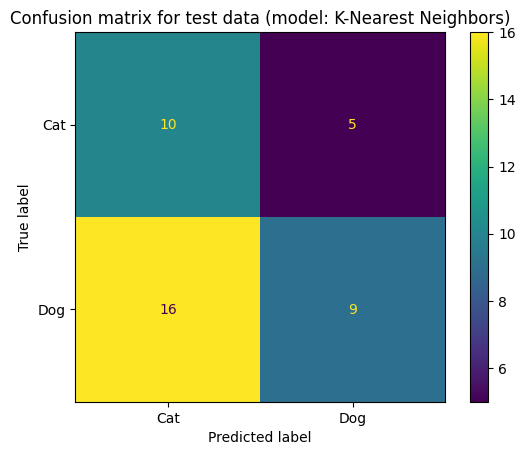

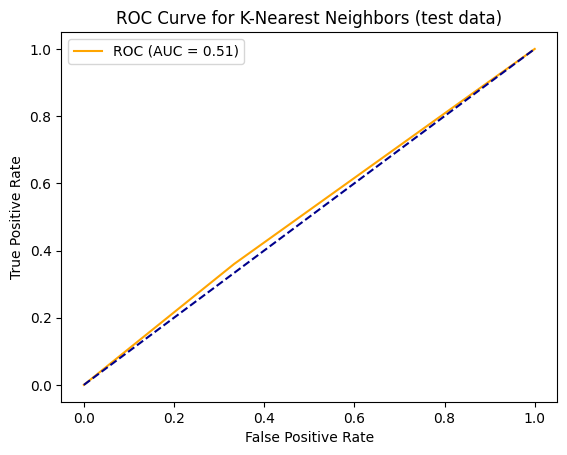

Classification Report for test data (key: block_2, model: K-Nearest Neighbors) 
               precision    recall  f1-score   support

         Cat       0.38      0.67      0.49        15
         Dog       0.64      0.36      0.46        25

    accuracy                           0.47        40
   macro avg       0.51      0.51      0.47        40
weighted avg       0.55      0.47      0.47        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_2
Best parameters found for Logistic Regression: {'lr__C': 0.1, 'lr__penalty': 'l2'}
Best CV accuracy score: 0.6080067731011127
Model: Logistic Regression, test accuracy score: 0.625, test f1 Score: 0.6190476190476191


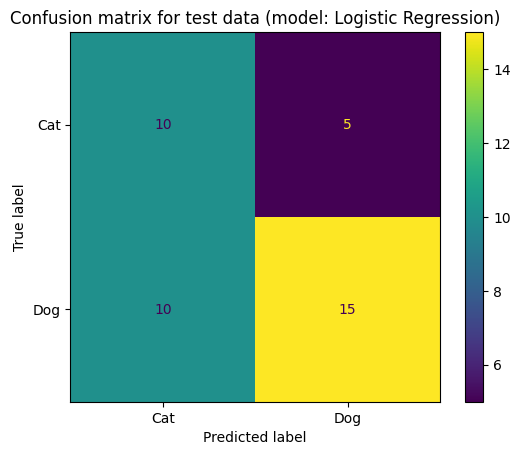

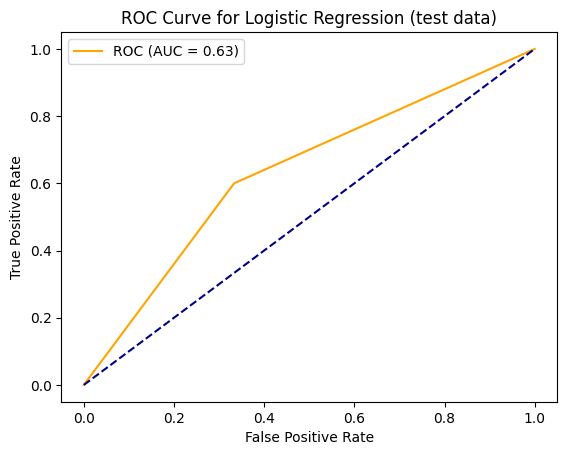

Classification Report for test data (key: block_2, model: Logistic Regression) 
               precision    recall  f1-score   support

         Cat       0.50      0.67      0.57        15
         Dog       0.75      0.60      0.67        25

    accuracy                           0.62        40
   macro avg       0.62      0.63      0.62        40
weighted avg       0.66      0.62      0.63        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_2
Best parameters found for Multi-Layer Perceptron: {'mlp__hidden_layer_sizes': (200, 100)}
Best CV accuracy score: 0.5884131591678762
Model: Multi-Layer Perceptron, test accuracy score: 0.65, test f1 Score: 0.6491228070175439


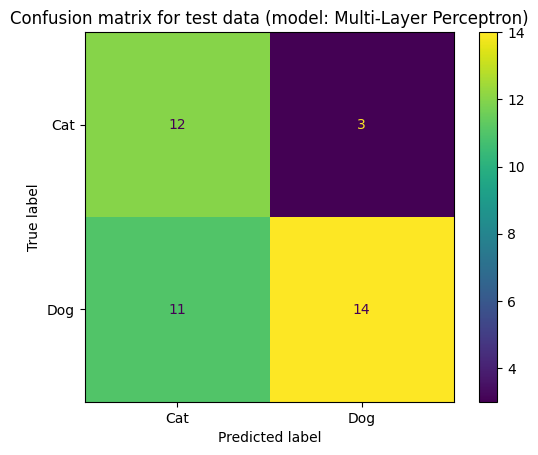

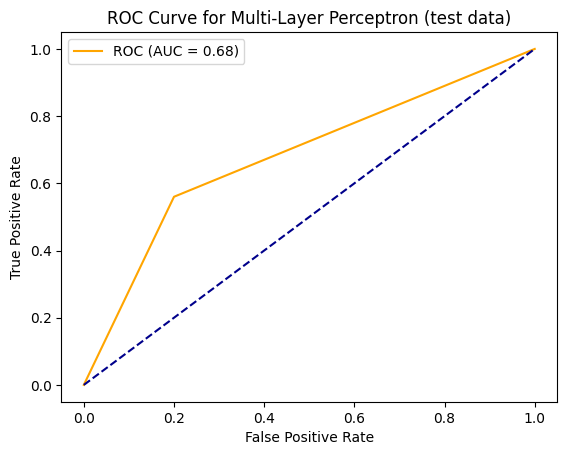

Classification Report for test data (key: block_2, model: Multi-Layer Perceptron) 
               precision    recall  f1-score   support

         Cat       0.52      0.80      0.63        15
         Dog       0.82      0.56      0.67        25

    accuracy                           0.65        40
   macro avg       0.67      0.68      0.65        40
weighted avg       0.71      0.65      0.65        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_2
Best parameters found for Support Vector Machine: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best CV accuracy score: 0.6140541848089017
Model: Support Vector Machine, test accuracy score: 0.525, test f1 Score: 0.5223130106851037


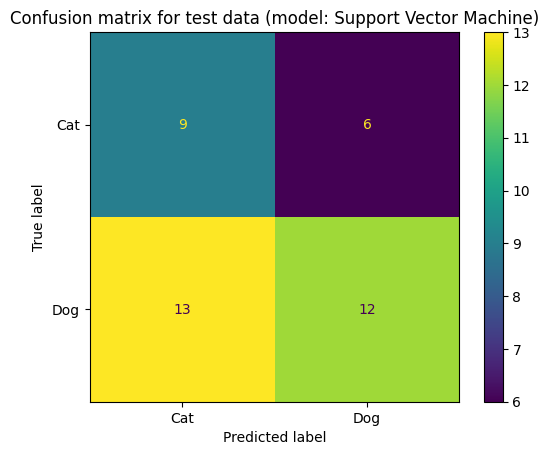

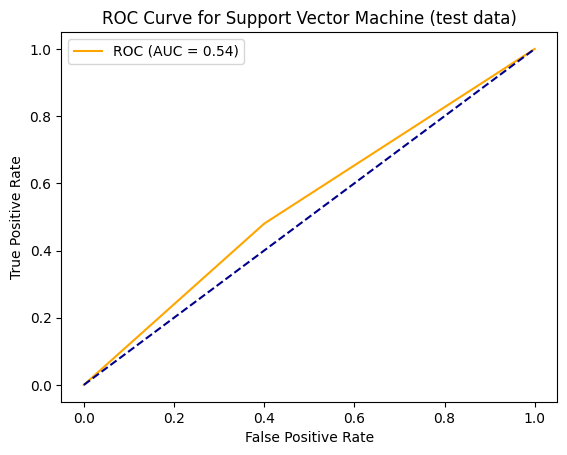

Classification Report for test data (key: block_2, model: Support Vector Machine) 
               precision    recall  f1-score   support

         Cat       0.41      0.60      0.49        15
         Dog       0.67      0.48      0.56        25

    accuracy                           0.53        40
   macro avg       0.54      0.54      0.52        40
weighted avg       0.57      0.53      0.53        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_2
Best parameters found for Random Forest: {'rf__max_depth': None, 'rf__n_estimators': 150}
Best CV accuracy score: 0.6711417513304306
Model: Random Forest, test accuracy score: 0.5, test f1 Score: 0.4949494949494949


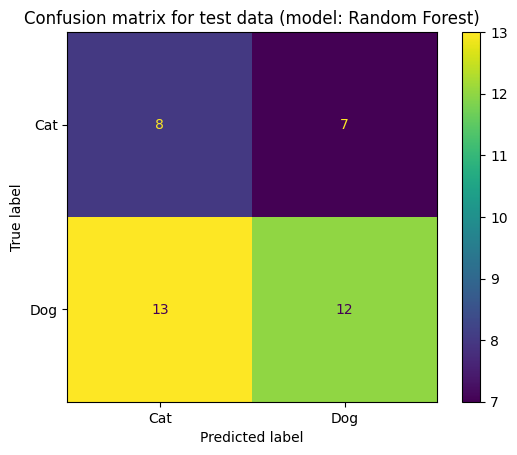

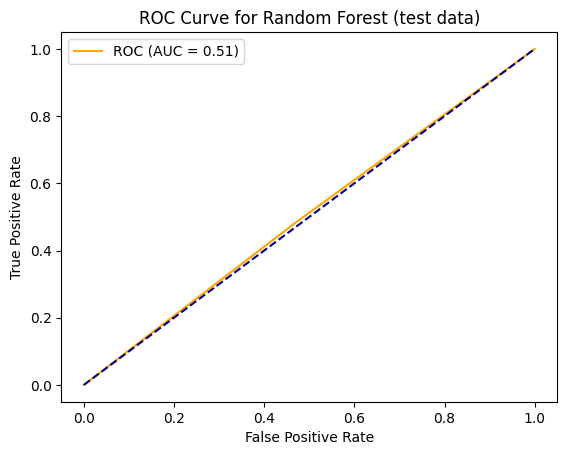

Classification Report for test data (key: block_2, model: Random Forest) 
               precision    recall  f1-score   support

         Cat       0.38      0.53      0.44        15
         Dog       0.63      0.48      0.55        25

    accuracy                           0.50        40
   macro avg       0.51      0.51      0.49        40
weighted avg       0.54      0.50      0.51        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_3
Best parameters found for K-Nearest Neighbors: {'knn__n_neighbors': 3}
Best CV accuracy score: 0.5694242864054185
Model: K-Nearest Neighbors, test accuracy score: 0.55, test f1 Score: 0.5488721804511278


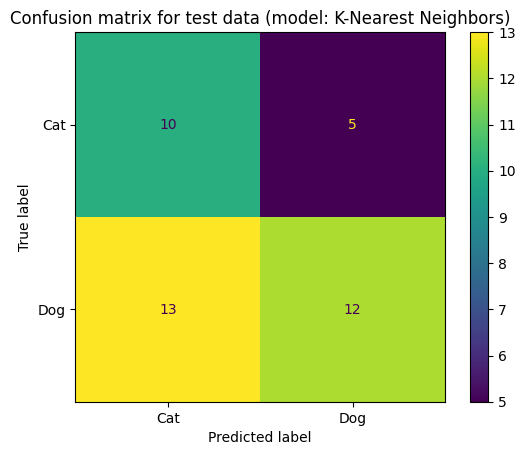

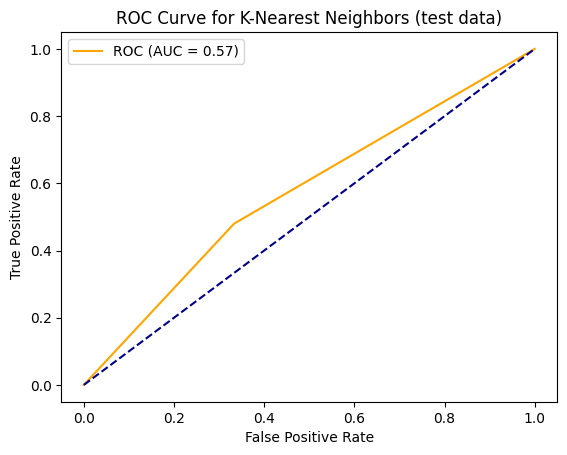

Classification Report for test data (key: block_3, model: K-Nearest Neighbors) 
               precision    recall  f1-score   support

         Cat       0.43      0.67      0.53        15
         Dog       0.71      0.48      0.57        25

    accuracy                           0.55        40
   macro avg       0.57      0.57      0.55        40
weighted avg       0.60      0.55      0.55        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_3
Best parameters found for Multi-Layer Perceptron: {'mlp__hidden_layer_sizes': (200, 100)}
Best CV accuracy score: 0.5440251572327044
Model: Multi-Layer Perceptron, test accuracy score: 0.525, test f1 Score: 0.5099935525467441


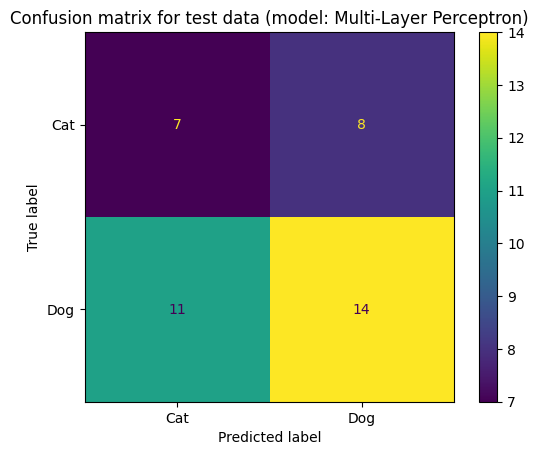

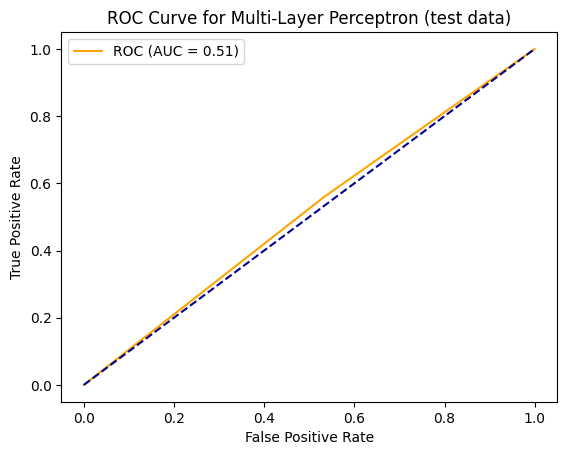

Classification Report for test data (key: block_3, model: Multi-Layer Perceptron) 
               precision    recall  f1-score   support

         Cat       0.39      0.47      0.42        15
         Dog       0.64      0.56      0.60        25

    accuracy                           0.53        40
   macro avg       0.51      0.51      0.51        40
weighted avg       0.54      0.53      0.53        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_3
Best parameters found for Logistic Regression: {'lr__C': 1, 'lr__penalty': 'l2'}
Best CV accuracy score: 0.626632801161103
Model: Logistic Regression, test accuracy score: 0.65, test f1 Score: 0.6464646464646464


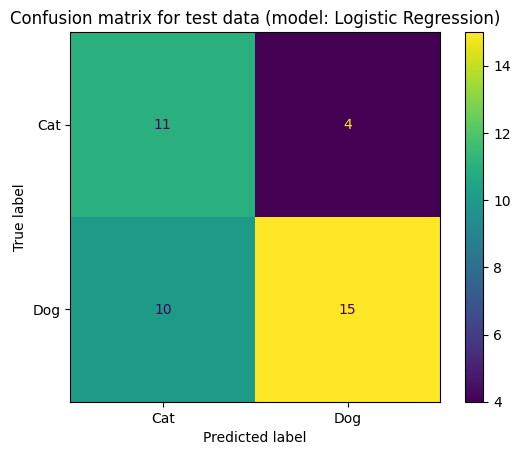

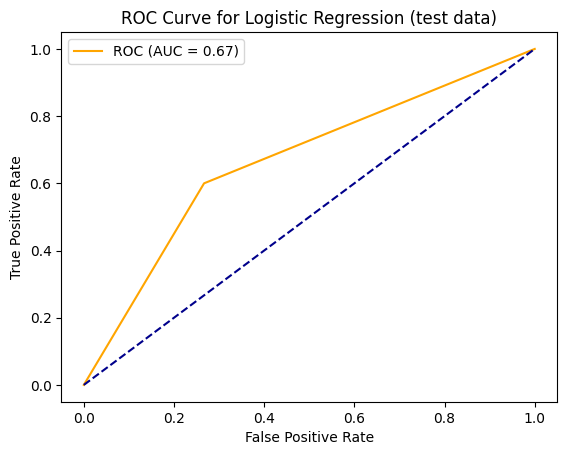

Classification Report for test data (key: block_3, model: Logistic Regression) 
               precision    recall  f1-score   support

         Cat       0.52      0.73      0.61        15
         Dog       0.79      0.60      0.68        25

    accuracy                           0.65        40
   macro avg       0.66      0.67      0.65        40
weighted avg       0.69      0.65      0.66        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_3
Best parameters found for Support Vector Machine: {'svm__C': 10, 'svm__kernel': 'linear'}
Best CV accuracy score: 0.6263909046927915
Model: Support Vector Machine, test accuracy score: 0.7, test f1 Score: 0.6875


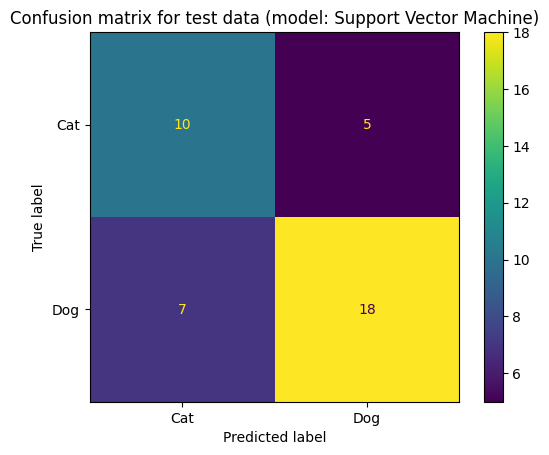

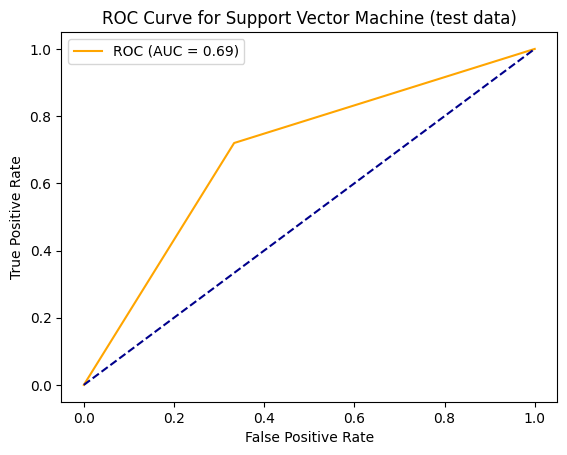

Classification Report for test data (key: block_3, model: Support Vector Machine) 
               precision    recall  f1-score   support

         Cat       0.59      0.67      0.62        15
         Dog       0.78      0.72      0.75        25

    accuracy                           0.70        40
   macro avg       0.69      0.69      0.69        40
weighted avg       0.71      0.70      0.70        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_3
Best parameters found for Random Forest: {'rf__max_depth': None, 'rf__n_estimators': 100}
Best CV accuracy score: 0.5630140299951621
Model: Random Forest, test accuracy score: 0.55, test f1 Score: 0.5488721804511278


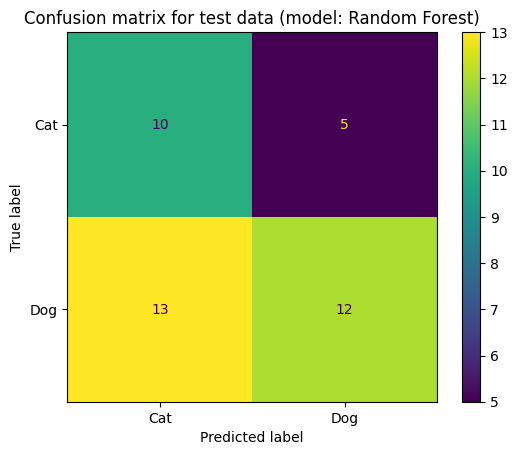

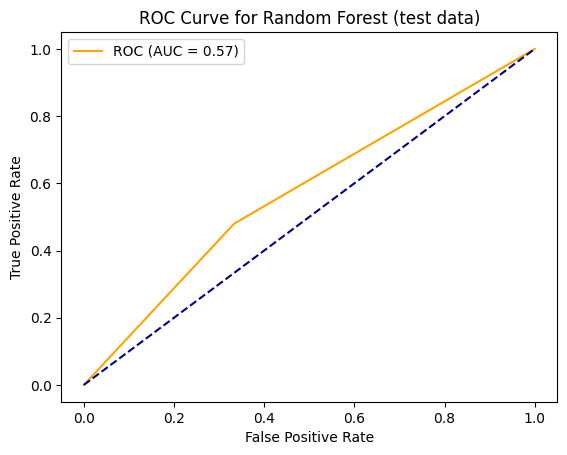

Classification Report for test data (key: block_3, model: Random Forest) 
               precision    recall  f1-score   support

         Cat       0.43      0.67      0.53        15
         Dog       0.71      0.48      0.57        25

    accuracy                           0.55        40
   macro avg       0.57      0.57      0.55        40
weighted avg       0.60      0.55      0.55        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_4
Best parameters found for K-Nearest Neighbors: {'knn__n_neighbors': 7}
Best CV accuracy score: 0.7848330914368651
Model: K-Nearest Neighbors, test accuracy score: 0.725, test f1 Score: 0.7206349206349206


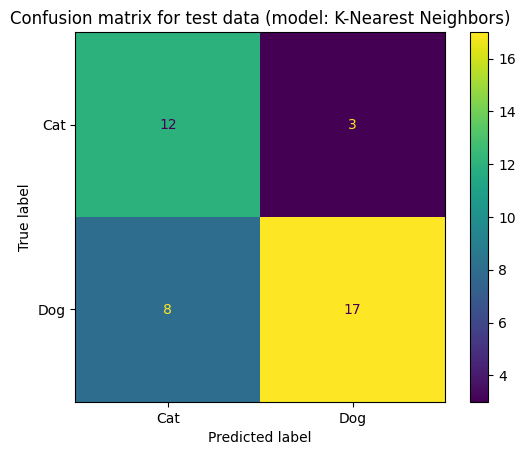

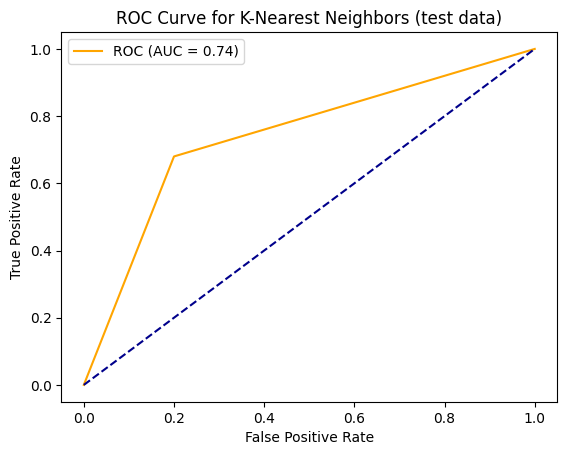

Classification Report for test data (key: block_4, model: K-Nearest Neighbors) 
               precision    recall  f1-score   support

         Cat       0.60      0.80      0.69        15
         Dog       0.85      0.68      0.76        25

    accuracy                           0.72        40
   macro avg       0.72      0.74      0.72        40
weighted avg       0.76      0.72      0.73        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_4
Best parameters found for Multi-Layer Perceptron: {'mlp__hidden_layer_sizes': (100, 50)}
Best CV accuracy score: 0.7275036284470247
Model: Multi-Layer Perceptron, test accuracy score: 0.7, test f1 Score: 0.6992481203007519


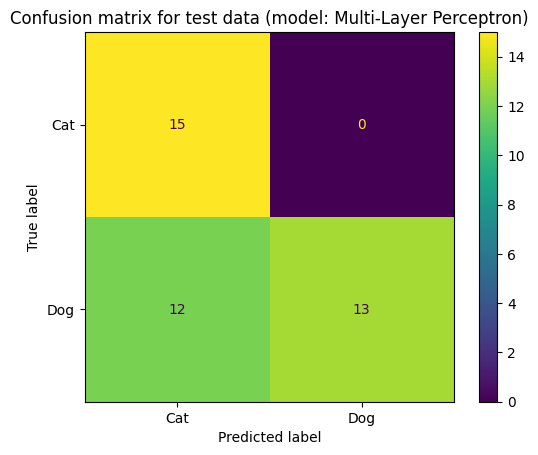

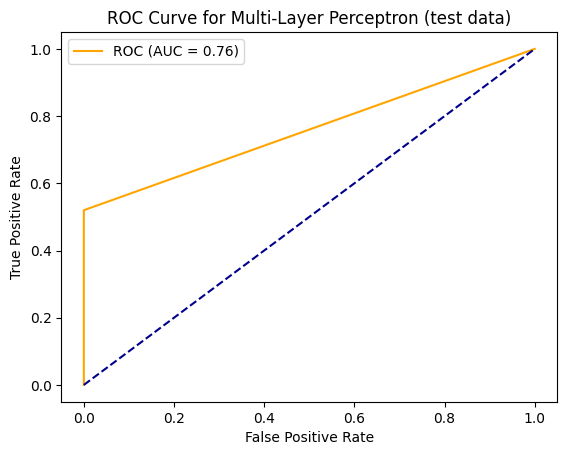

Classification Report for test data (key: block_4, model: Multi-Layer Perceptron) 
               precision    recall  f1-score   support

         Cat       0.56      1.00      0.71        15
         Dog       1.00      0.52      0.68        25

    accuracy                           0.70        40
   macro avg       0.78      0.76      0.70        40
weighted avg       0.83      0.70      0.70        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_4
Best parameters found for Logistic Regression: {'lr__C': 0.1, 'lr__penalty': 'l2'}
Best CV accuracy score: 0.7027092404450895
Model: Logistic Regression, test accuracy score: 0.725, test f1 Score: 0.7234443746071653


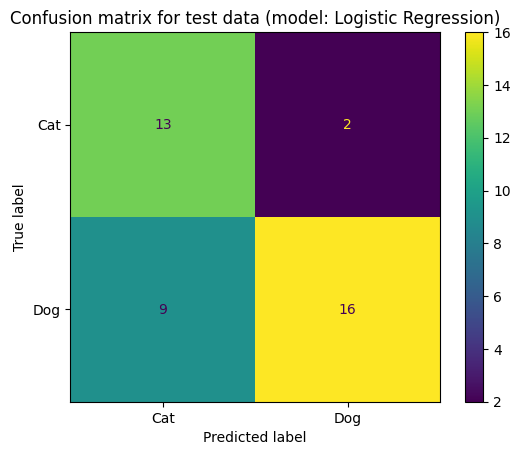

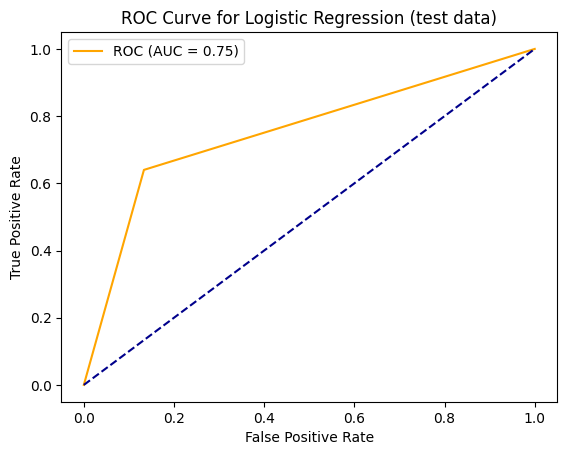

Classification Report for test data (key: block_4, model: Logistic Regression) 
               precision    recall  f1-score   support

         Cat       0.59      0.87      0.70        15
         Dog       0.89      0.64      0.74        25

    accuracy                           0.72        40
   macro avg       0.74      0.75      0.72        40
weighted avg       0.78      0.72      0.73        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_4
Best parameters found for Support Vector Machine: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best CV accuracy score: 0.7972907595549105
Model: Support Vector Machine, test accuracy score: 0.625, test f1 Score: 0.6247654784240151


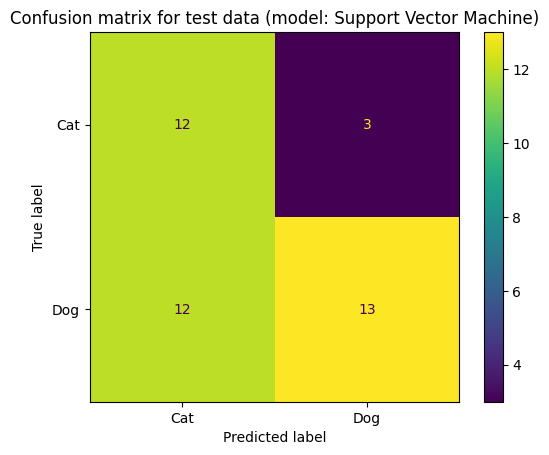

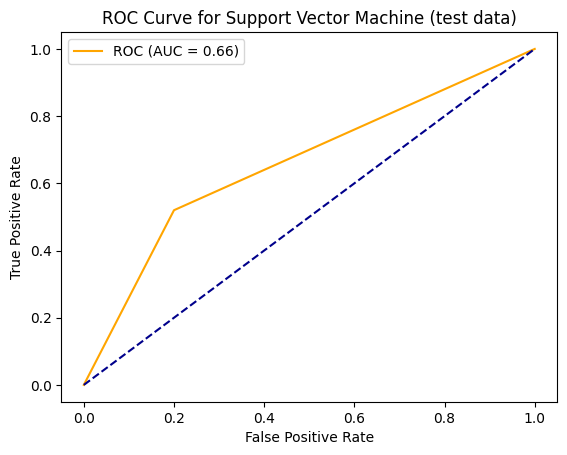

Classification Report for test data (key: block_4, model: Support Vector Machine) 
               precision    recall  f1-score   support

         Cat       0.50      0.80      0.62        15
         Dog       0.81      0.52      0.63        25

    accuracy                           0.62        40
   macro avg       0.66      0.66      0.62        40
weighted avg       0.70      0.62      0.63        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_4
Best parameters found for Random Forest: {'rf__max_depth': None, 'rf__n_estimators': 50}
Best CV accuracy score: 0.7595549104983067
Model: Random Forest, test accuracy score: 0.7, test f1 Score: 0.6992481203007519


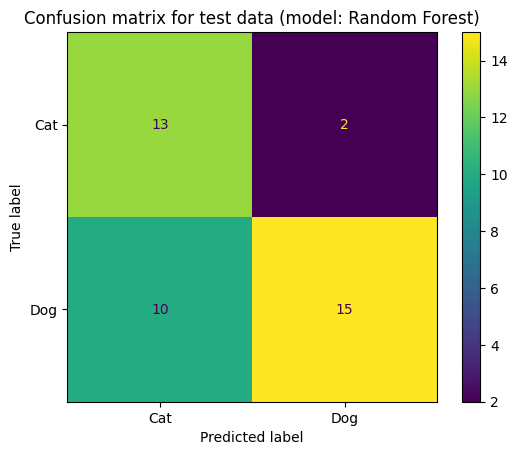

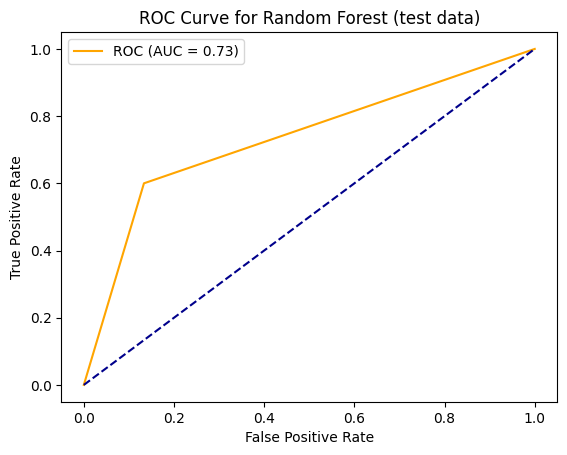

Classification Report for test data (key: block_4, model: Random Forest) 
               precision    recall  f1-score   support

         Cat       0.57      0.87      0.68        15
         Dog       0.88      0.60      0.71        25

    accuracy                           0.70        40
   macro avg       0.72      0.73      0.70        40
weighted avg       0.76      0.70      0.70        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_5
Best parameters found for K-Nearest Neighbors: {'knn__n_neighbors': 5}
Best CV accuracy score: 0.6771891630382196
Model: K-Nearest Neighbors, test accuracy score: 0.725, test f1 Score: 0.7248280175109443


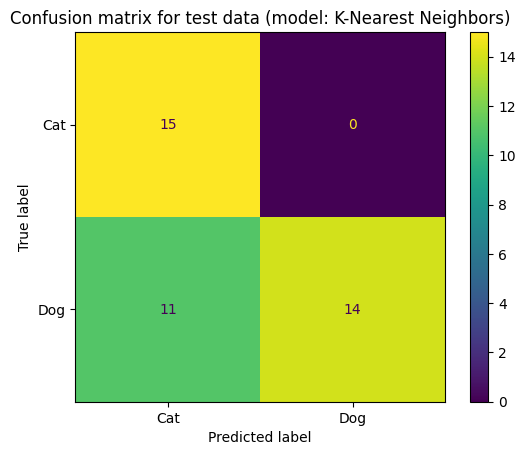

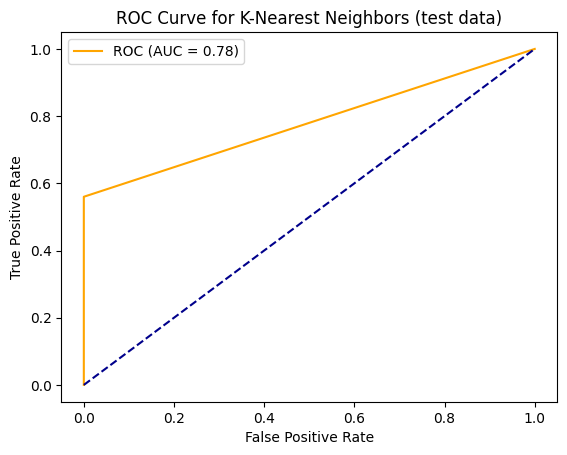

Classification Report for test data (key: block_5, model: K-Nearest Neighbors) 
               precision    recall  f1-score   support

         Cat       0.58      1.00      0.73        15
         Dog       1.00      0.56      0.72        25

    accuracy                           0.72        40
   macro avg       0.79      0.78      0.72        40
weighted avg       0.84      0.72      0.72        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_5
Best parameters found for Logistic Regression: {'lr__C': 0.01, 'lr__penalty': 'l2'}
Best CV accuracy score: 0.791485244315433
Model: Logistic Regression, test accuracy score: 0.725, test f1 Score: 0.7234443746071653


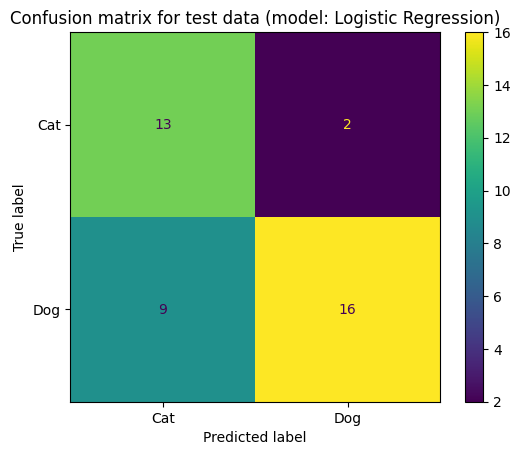

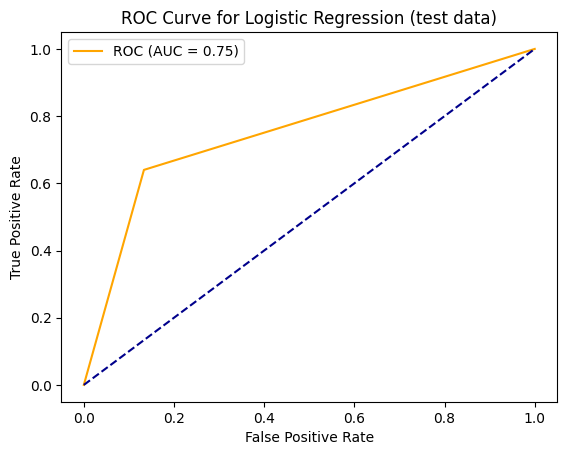

Classification Report for test data (key: block_5, model: Logistic Regression) 
               precision    recall  f1-score   support

         Cat       0.59      0.87      0.70        15
         Dog       0.89      0.64      0.74        25

    accuracy                           0.72        40
   macro avg       0.74      0.75      0.72        40
weighted avg       0.78      0.72      0.73        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_5
Best parameters found for Support Vector Machine: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best CV accuracy score: 0.8288582486695694
Model: Support Vector Machine, test accuracy score: 0.825, test f1 Score: 0.819471308833011


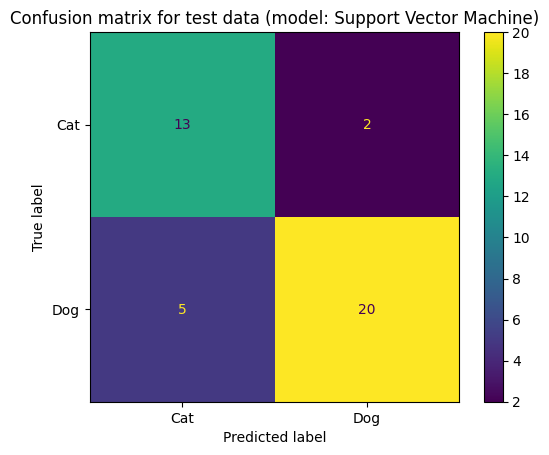

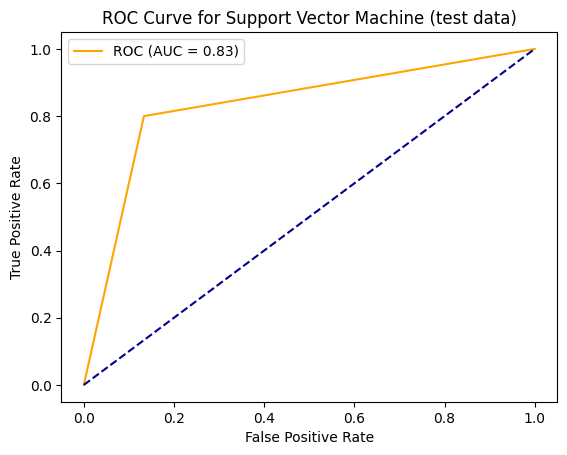

Classification Report for test data (key: block_5, model: Support Vector Machine) 
               precision    recall  f1-score   support

         Cat       0.72      0.87      0.79        15
         Dog       0.91      0.80      0.85        25

    accuracy                           0.82        40
   macro avg       0.82      0.83      0.82        40
weighted avg       0.84      0.82      0.83        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_5
Best parameters found for Multi-Layer Perceptron: {'mlp__hidden_layer_sizes': (200, 150, 100)}
Best CV accuracy score: 0.7913642960812771
Model: Multi-Layer Perceptron, test accuracy score: 0.675, test f1 Score: 0.6698412698412699


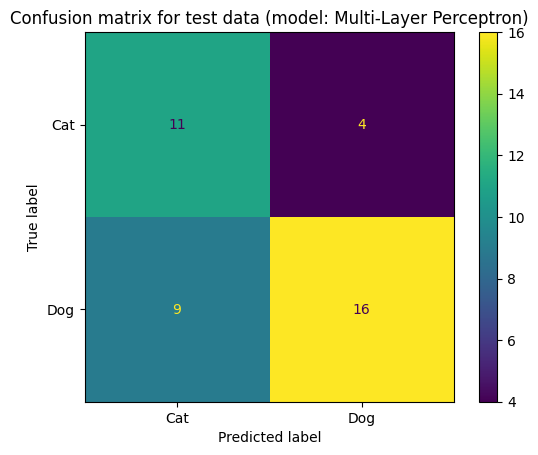

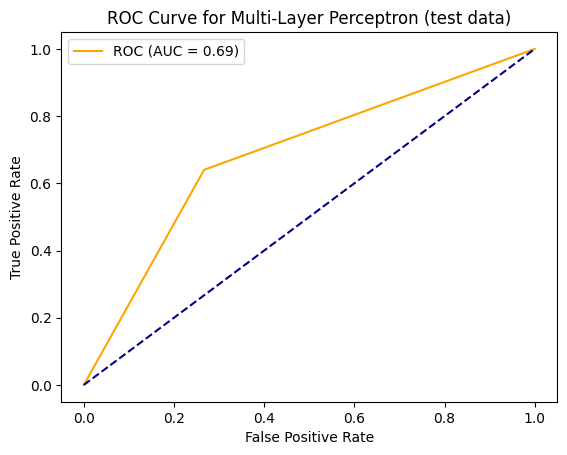

Classification Report for test data (key: block_5, model: Multi-Layer Perceptron) 
               precision    recall  f1-score   support

         Cat       0.55      0.73      0.63        15
         Dog       0.80      0.64      0.71        25

    accuracy                           0.68        40
   macro avg       0.68      0.69      0.67        40
weighted avg       0.71      0.68      0.68        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_5
Best parameters found for Random Forest: {'rf__max_depth': 3, 'rf__n_estimators': 50}
Best CV accuracy score: 0.7659651669085631
Model: Random Forest, test accuracy score: 0.65, test f1 Score: 0.6491228070175439


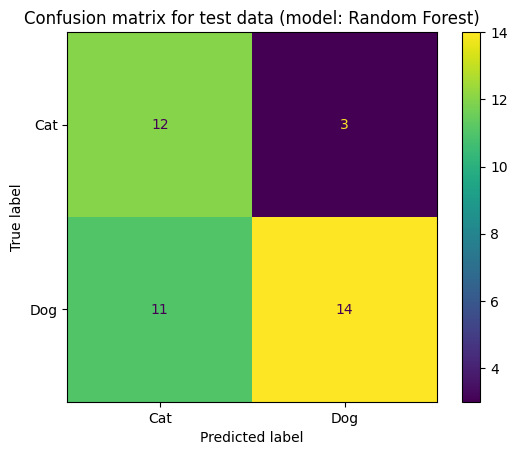

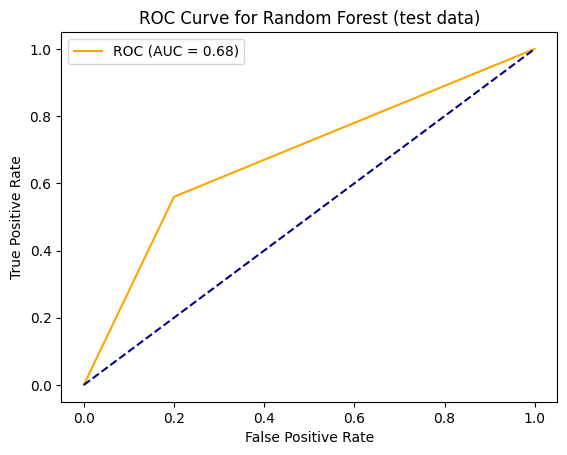

Classification Report for test data (key: block_5, model: Random Forest) 
               precision    recall  f1-score   support

         Cat       0.52      0.80      0.63        15
         Dog       0.82      0.56      0.67        25

    accuracy                           0.65        40
   macro avg       0.67      0.68      0.65        40
weighted avg       0.71      0.65      0.65        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_6
Best parameters found for K-Nearest Neighbors: {'knn__n_neighbors': 7}
Best CV accuracy score: 0.7532656023222061
Model: K-Nearest Neighbors, test accuracy score: 0.575, test f1 Score: 0.5523370638578011


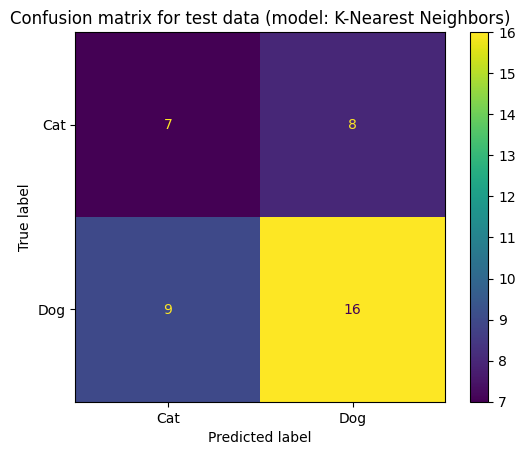

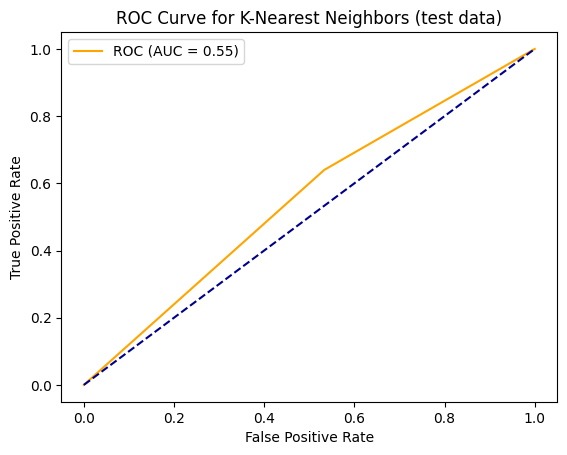

Classification Report for test data (key: block_6, model: K-Nearest Neighbors) 
               precision    recall  f1-score   support

         Cat       0.44      0.47      0.45        15
         Dog       0.67      0.64      0.65        25

    accuracy                           0.57        40
   macro avg       0.55      0.55      0.55        40
weighted avg       0.58      0.57      0.58        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_6
Best parameters found for Logistic Regression: {'lr__C': 0.1, 'lr__penalty': 'l2'}
Best CV accuracy score: 0.7718916303821964
Model: Logistic Regression, test accuracy score: 0.775, test f1 Score: 0.7678916827852997


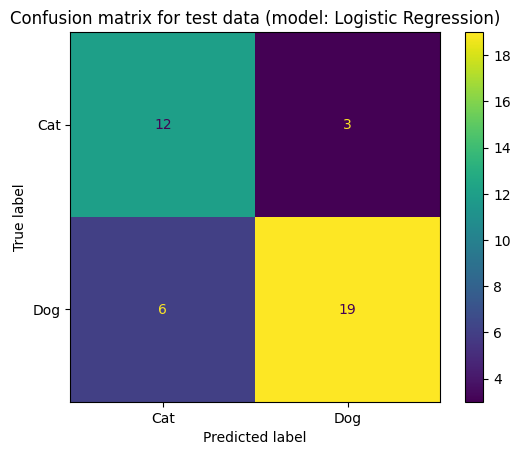

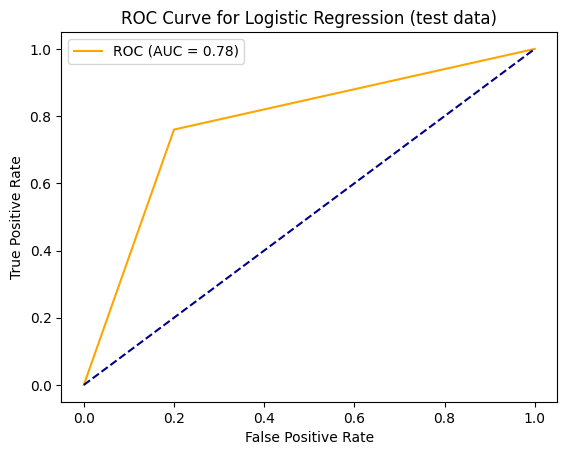

Classification Report for test data (key: block_6, model: Logistic Regression) 
               precision    recall  f1-score   support

         Cat       0.67      0.80      0.73        15
         Dog       0.86      0.76      0.81        25

    accuracy                           0.78        40
   macro avg       0.77      0.78      0.77        40
weighted avg       0.79      0.78      0.78        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_6
Best parameters found for Multi-Layer Perceptron: {'mlp__hidden_layer_sizes': (200, 150, 100)}
Best CV accuracy score: 0.7590711175616836
Model: Multi-Layer Perceptron, test accuracy score: 0.75, test f1 Score: 0.7474747474747474


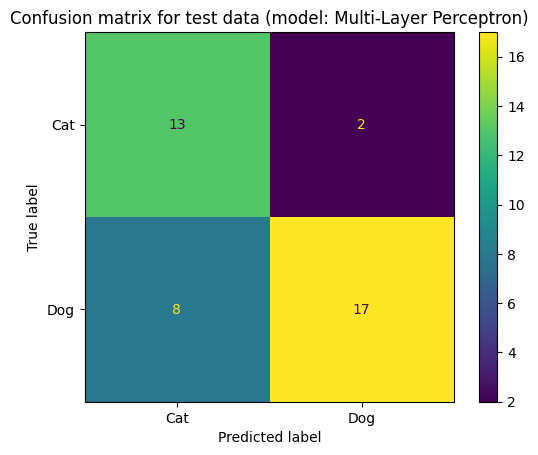

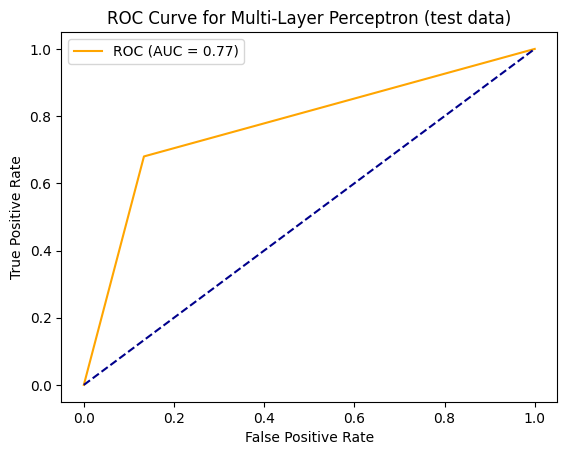

Classification Report for test data (key: block_6, model: Multi-Layer Perceptron) 
               precision    recall  f1-score   support

         Cat       0.62      0.87      0.72        15
         Dog       0.89      0.68      0.77        25

    accuracy                           0.75        40
   macro avg       0.76      0.77      0.75        40
weighted avg       0.79      0.75      0.75        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_6
Best parameters found for Support Vector Machine: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best CV accuracy score: 0.7850749879051766
Model: Support Vector Machine, test accuracy score: 0.7, test f1 Score: 0.7


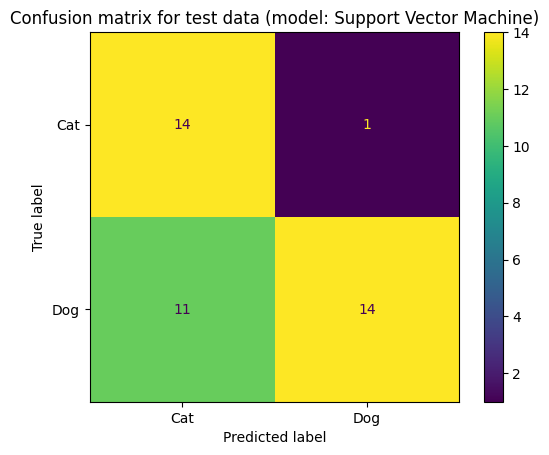

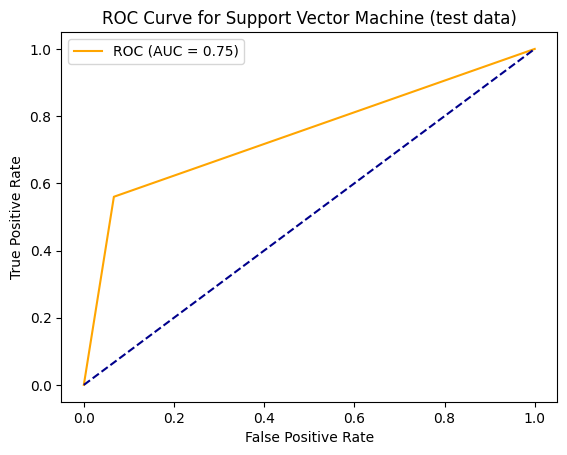

Classification Report for test data (key: block_6, model: Support Vector Machine) 
               precision    recall  f1-score   support

         Cat       0.56      0.93      0.70        15
         Dog       0.93      0.56      0.70        25

    accuracy                           0.70        40
   macro avg       0.75      0.75      0.70        40
weighted avg       0.79      0.70      0.70        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_6
Best parameters found for Random Forest: {'rf__max_depth': 5, 'rf__n_estimators': 50}
Best CV accuracy score: 0.7907595549104983
Model: Random Forest, test accuracy score: 0.75, test f1 Score: 0.75


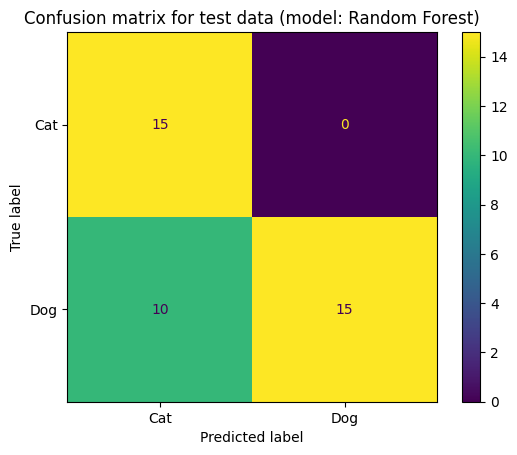

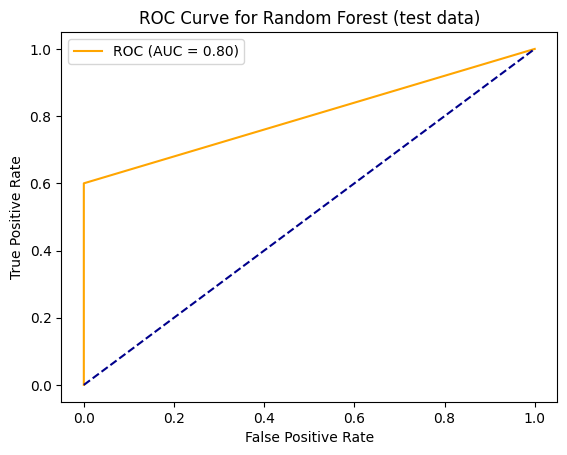

Classification Report for test data (key: block_6, model: Random Forest) 
               precision    recall  f1-score   support

         Cat       0.60      1.00      0.75        15
         Dog       1.00      0.60      0.75        25

    accuracy                           0.75        40
   macro avg       0.80      0.80      0.75        40
weighted avg       0.85      0.75      0.75        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_7
Best parameters found for K-Nearest Neighbors: {'knn__n_neighbors': 5}
Best CV accuracy score: 0.6777939042089985
Model: K-Nearest Neighbors, test accuracy score: 0.625, test f1 Score: 0.6247654784240151


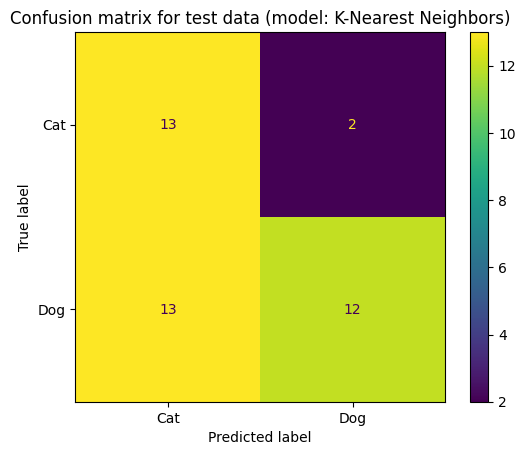

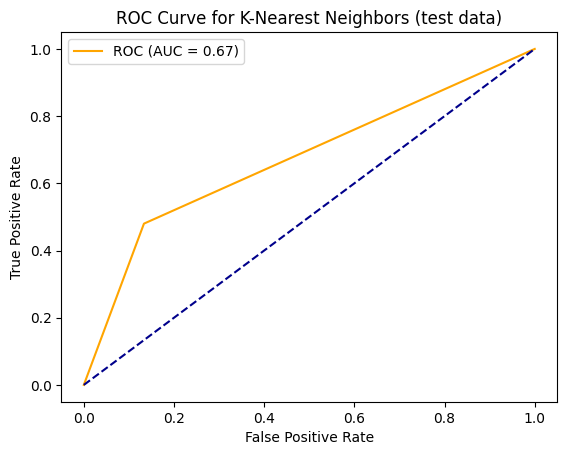

Classification Report for test data (key: block_7, model: K-Nearest Neighbors) 
               precision    recall  f1-score   support

         Cat       0.50      0.87      0.63        15
         Dog       0.86      0.48      0.62        25

    accuracy                           0.62        40
   macro avg       0.68      0.67      0.62        40
weighted avg       0.72      0.62      0.62        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_7
Best parameters found for Multi-Layer Perceptron: {'mlp__hidden_layer_sizes': (100,)}
Best CV accuracy score: 0.6713836477987422
Model: Multi-Layer Perceptron, test accuracy score: 0.65, test f1 Score: 0.65


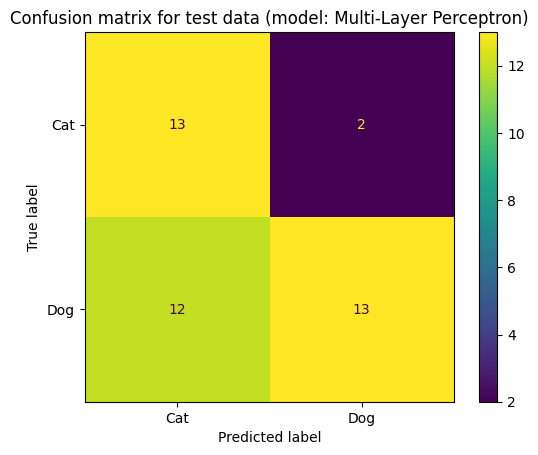

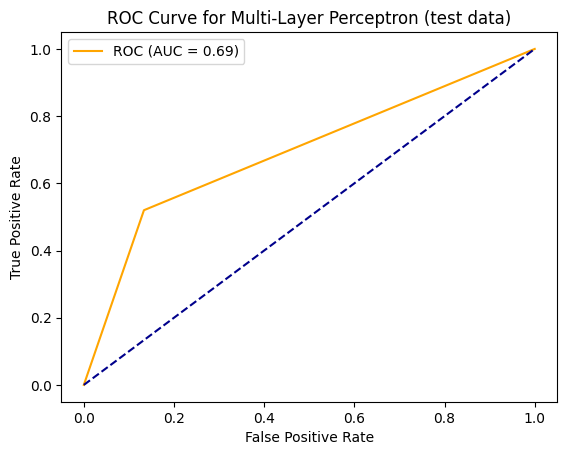

Classification Report for test data (key: block_7, model: Multi-Layer Perceptron) 
               precision    recall  f1-score   support

         Cat       0.52      0.87      0.65        15
         Dog       0.87      0.52      0.65        25

    accuracy                           0.65        40
   macro avg       0.69      0.69      0.65        40
weighted avg       0.74      0.65      0.65        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_7
Best parameters found for Logistic Regression: {'lr__C': 0.01, 'lr__penalty': 'l2'}
Best CV accuracy score: 0.5950653120464441
Model: Logistic Regression, test accuracy score: 0.675, test f1 Score: 0.6731615336266499


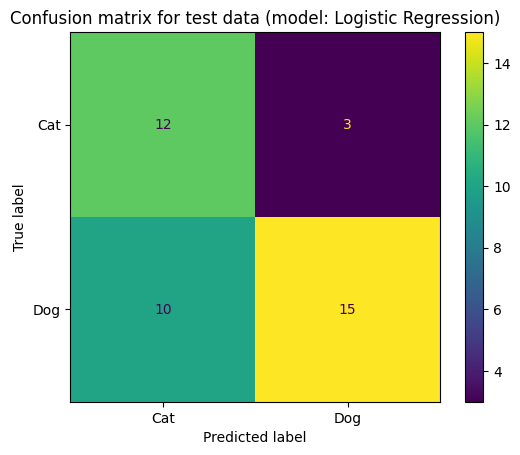

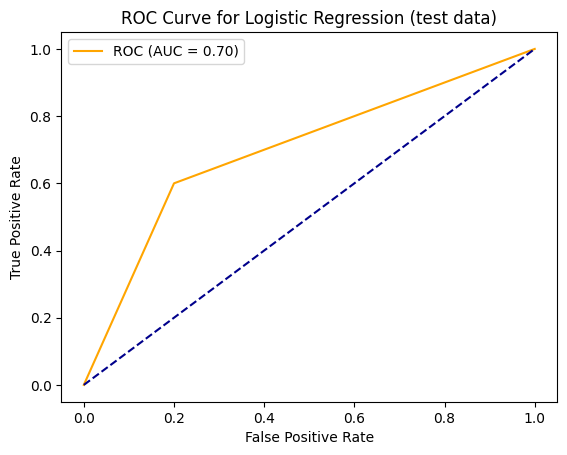

Classification Report for test data (key: block_7, model: Logistic Regression) 
               precision    recall  f1-score   support

         Cat       0.55      0.80      0.65        15
         Dog       0.83      0.60      0.70        25

    accuracy                           0.68        40
   macro avg       0.69      0.70      0.67        40
weighted avg       0.73      0.68      0.68        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_7
Best parameters found for Support Vector Machine: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best CV accuracy score: 0.6903725205611998
Model: Support Vector Machine, test accuracy score: 0.725, test f1 Score: 0.7163120567375887


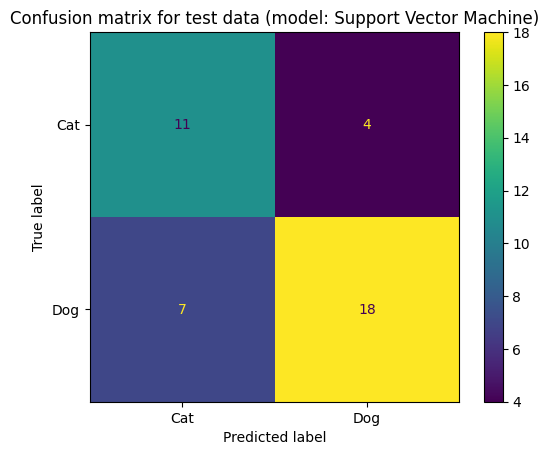

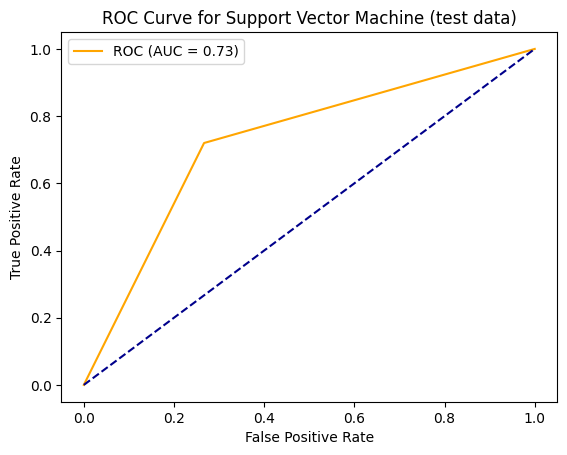

Classification Report for test data (key: block_7, model: Support Vector Machine) 
               precision    recall  f1-score   support

         Cat       0.61      0.73      0.67        15
         Dog       0.82      0.72      0.77        25

    accuracy                           0.72        40
   macro avg       0.71      0.73      0.72        40
weighted avg       0.74      0.72      0.73        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_7
Best parameters found for Random Forest: {'rf__max_depth': None, 'rf__n_estimators': 50}
Best CV accuracy score: 0.7216981132075472
Model: Random Forest, test accuracy score: 0.675, test f1 Score: 0.6731615336266499


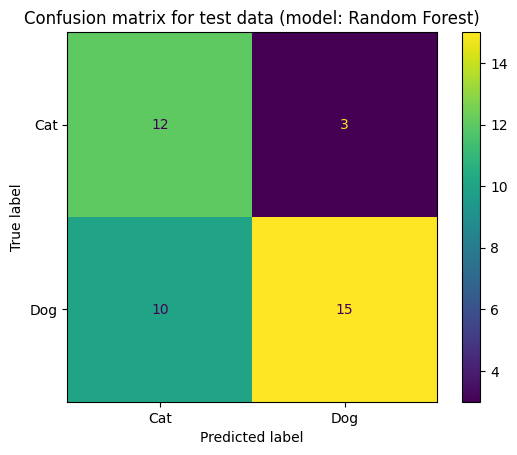

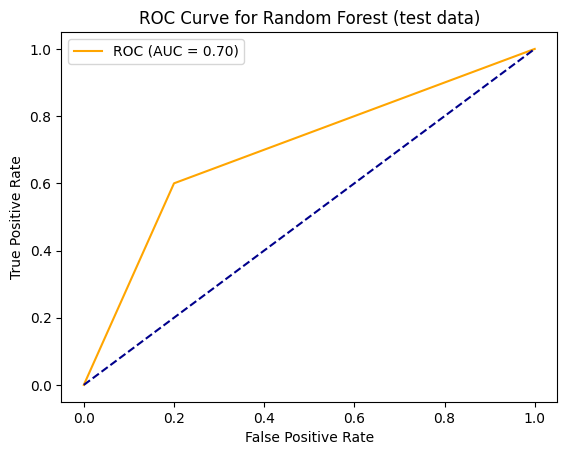

Classification Report for test data (key: block_7, model: Random Forest) 
               precision    recall  f1-score   support

         Cat       0.55      0.80      0.65        15
         Dog       0.83      0.60      0.70        25

    accuracy                           0.68        40
   macro avg       0.69      0.70      0.67        40
weighted avg       0.73      0.68      0.68        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_8
Best parameters found for K-Nearest Neighbors: {'knn__n_neighbors': 5}
Best CV accuracy score: 0.7912433478471215
Model: K-Nearest Neighbors, test accuracy score: 0.775, test f1 Score: 0.7714285714285715


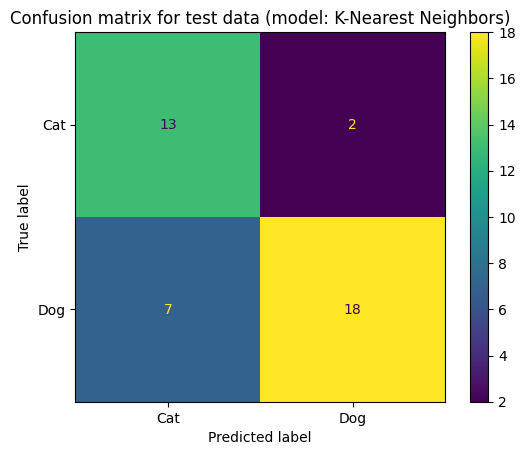

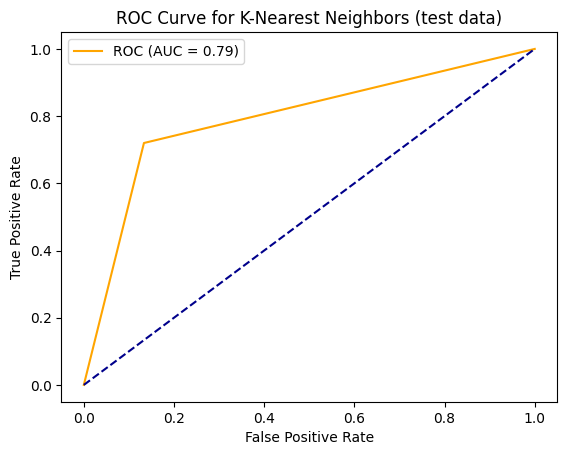

Classification Report for test data (key: block_8, model: K-Nearest Neighbors) 
               precision    recall  f1-score   support

         Cat       0.65      0.87      0.74        15
         Dog       0.90      0.72      0.80        25

    accuracy                           0.78        40
   macro avg       0.78      0.79      0.77        40
weighted avg       0.81      0.78      0.78        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_8
Best parameters found for Logistic Regression: {'lr__C': 0.01, 'lr__penalty': 'l2'}
Best CV accuracy score: 0.7215771649733914
Model: Logistic Regression, test accuracy score: 0.75, test f1 Score: 0.7493734335839599


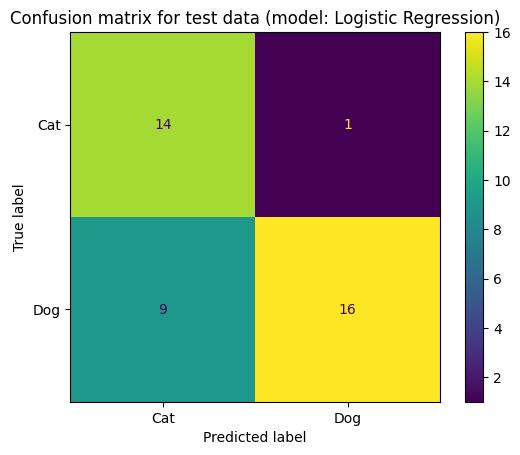

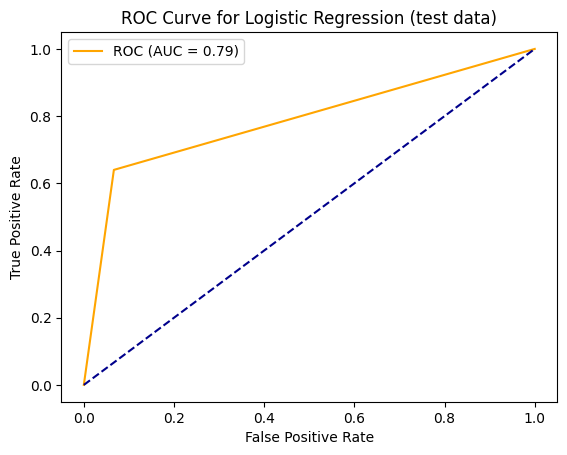

Classification Report for test data (key: block_8, model: Logistic Regression) 
               precision    recall  f1-score   support

         Cat       0.61      0.93      0.74        15
         Dog       0.94      0.64      0.76        25

    accuracy                           0.75        40
   macro avg       0.77      0.79      0.75        40
weighted avg       0.82      0.75      0.75        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_8
Best parameters found for Multi-Layer Perceptron: {'mlp__hidden_layer_sizes': (200, 100)}
Best CV accuracy score: 0.7848330914368651
Model: Multi-Layer Perceptron, test accuracy score: 0.75, test f1 Score: 0.7474747474747474


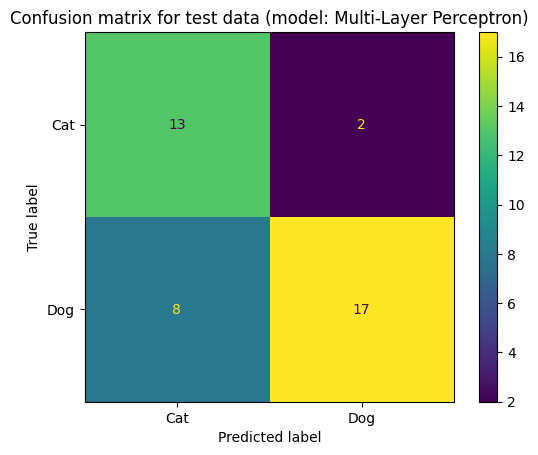

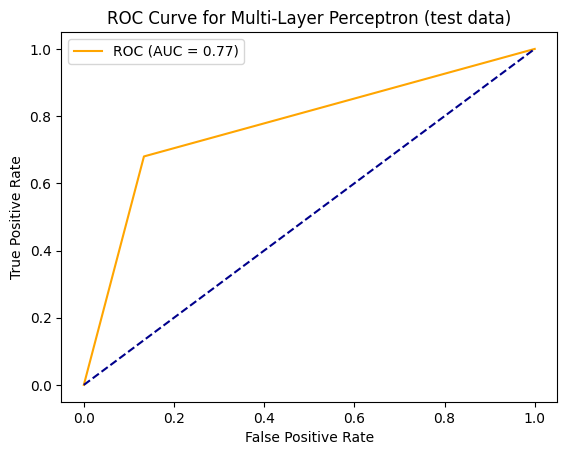

Classification Report for test data (key: block_8, model: Multi-Layer Perceptron) 
               precision    recall  f1-score   support

         Cat       0.62      0.87      0.72        15
         Dog       0.89      0.68      0.77        25

    accuracy                           0.75        40
   macro avg       0.76      0.77      0.75        40
weighted avg       0.79      0.75      0.75        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_8
Best parameters found for Support Vector Machine: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best CV accuracy score: 0.7594339622641509
Model: Support Vector Machine, test accuracy score: 0.8, test f1 Score: 0.797979797979798


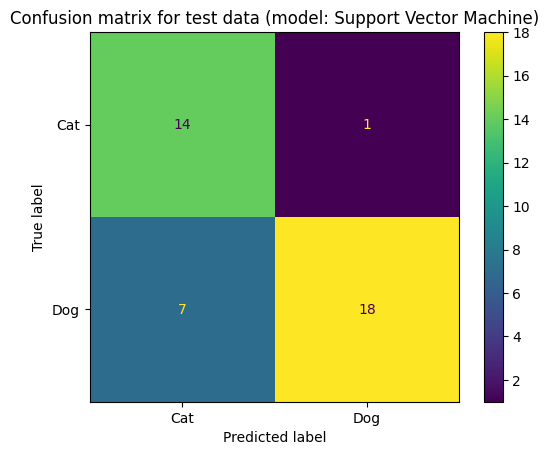

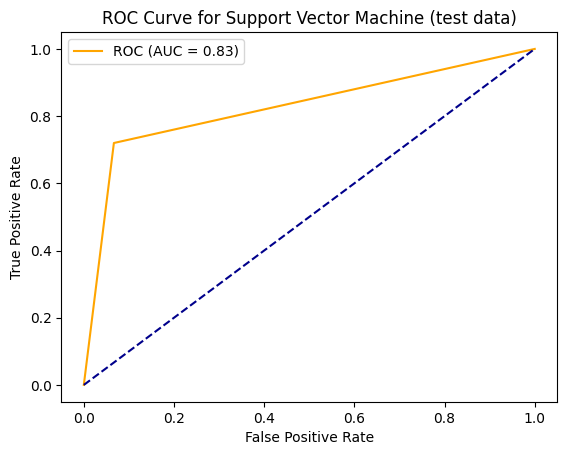

Classification Report for test data (key: block_8, model: Support Vector Machine) 
               precision    recall  f1-score   support

         Cat       0.67      0.93      0.78        15
         Dog       0.95      0.72      0.82        25

    accuracy                           0.80        40
   macro avg       0.81      0.83      0.80        40
weighted avg       0.84      0.80      0.80        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_8
Best parameters found for Random Forest: {'rf__max_depth': 5, 'rf__n_estimators': 150}
Best CV accuracy score: 0.7593130140299952
Model: Random Forest, test accuracy score: 0.775, test f1 Score: 0.7714285714285715


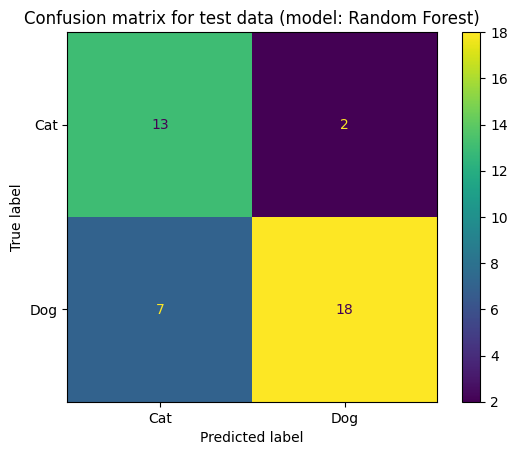

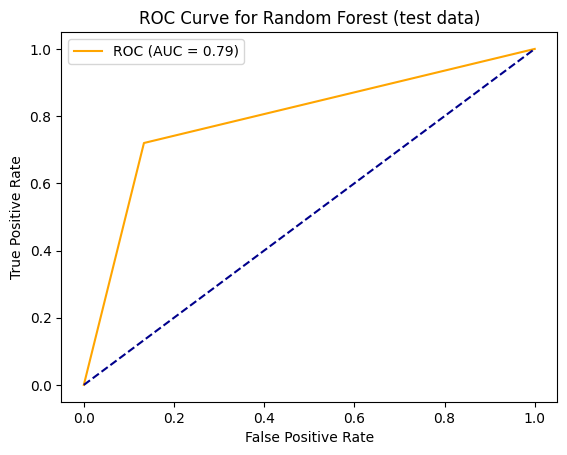

Classification Report for test data (key: block_8, model: Random Forest) 
               precision    recall  f1-score   support

         Cat       0.65      0.87      0.74        15
         Dog       0.90      0.72      0.80        25

    accuracy                           0.78        40
   macro avg       0.78      0.79      0.77        40
weighted avg       0.81      0.78      0.78        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_9
Best parameters found for K-Nearest Neighbors: {'knn__n_neighbors': 3}
Best CV accuracy score: 0.7152878567972908
Model: K-Nearest Neighbors, test accuracy score: 0.7, test f1 Score: 0.696969696969697


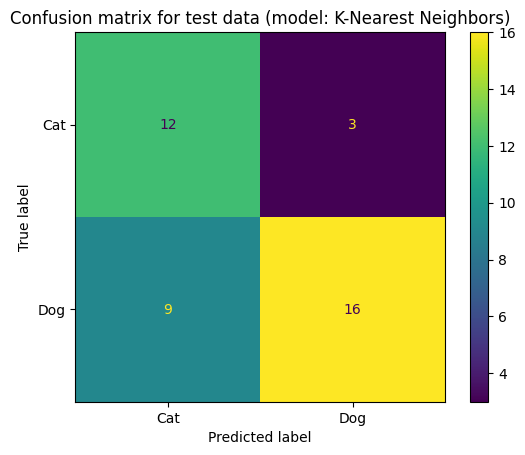

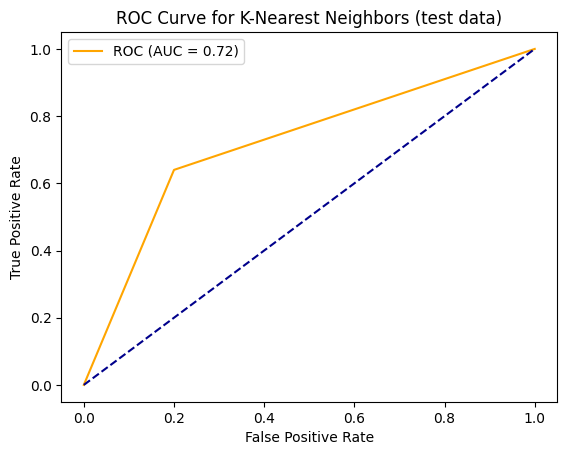

Classification Report for test data (key: block_9, model: K-Nearest Neighbors) 
               precision    recall  f1-score   support

         Cat       0.57      0.80      0.67        15
         Dog       0.84      0.64      0.73        25

    accuracy                           0.70        40
   macro avg       0.71      0.72      0.70        40
weighted avg       0.74      0.70      0.70        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_9
Best parameters found for Multi-Layer Perceptron: {'mlp__hidden_layer_sizes': (200, 150, 100)}
Best CV accuracy score: 0.7406869859700048
Model: Multi-Layer Perceptron, test accuracy score: 0.725, test f1 Score: 0.7163120567375887


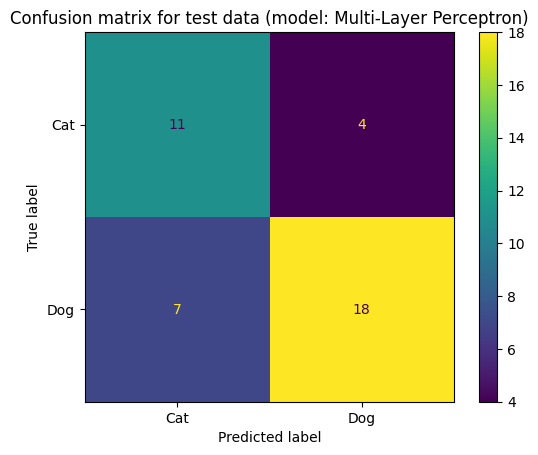

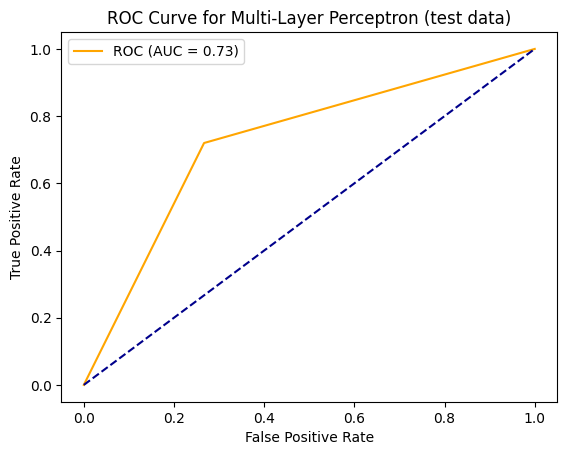

Classification Report for test data (key: block_9, model: Multi-Layer Perceptron) 
               precision    recall  f1-score   support

         Cat       0.61      0.73      0.67        15
         Dog       0.82      0.72      0.77        25

    accuracy                           0.72        40
   macro avg       0.71      0.73      0.72        40
weighted avg       0.74      0.72      0.73        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_9
Best parameters found for Support Vector Machine: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best CV accuracy score: 0.7659651669085631
Model: Support Vector Machine, test accuracy score: 0.75, test f1 Score: 0.7442455242966752


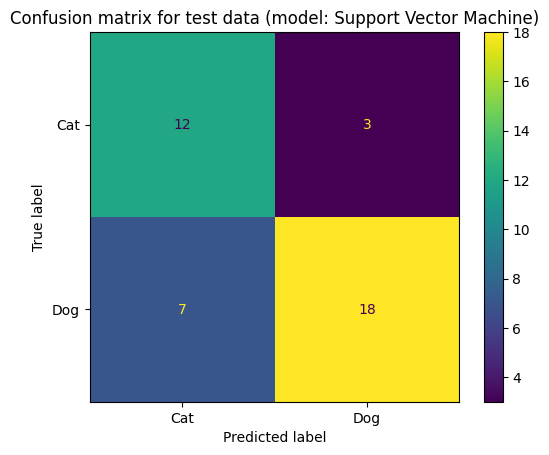

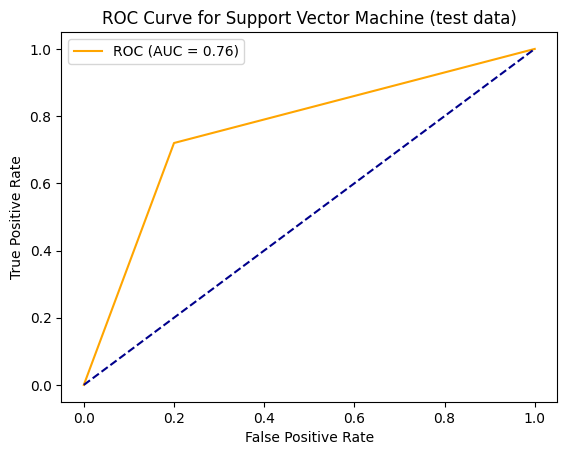

Classification Report for test data (key: block_9, model: Support Vector Machine) 
               precision    recall  f1-score   support

         Cat       0.63      0.80      0.71        15
         Dog       0.86      0.72      0.78        25

    accuracy                           0.75        40
   macro avg       0.74      0.76      0.74        40
weighted avg       0.77      0.75      0.75        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_9
Best parameters found for Logistic Regression: {'lr__C': 0.01, 'lr__penalty': 'l2'}
Best CV accuracy score: 0.7150459603289793
Model: Logistic Regression, test accuracy score: 0.7, test f1 Score: 0.696969696969697


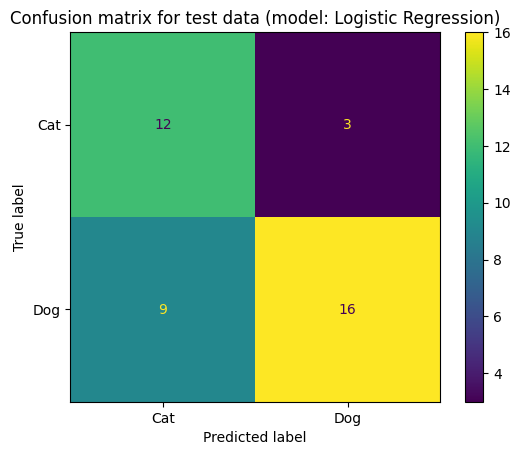

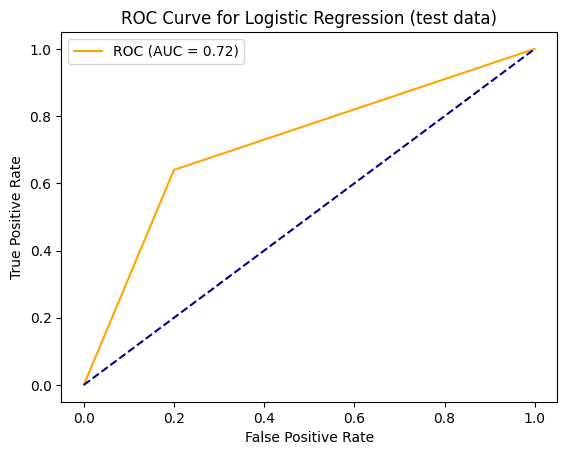

Classification Report for test data (key: block_9, model: Logistic Regression) 
               precision    recall  f1-score   support

         Cat       0.57      0.80      0.67        15
         Dog       0.84      0.64      0.73        25

    accuracy                           0.70        40
   macro avg       0.71      0.72      0.70        40
weighted avg       0.74      0.70      0.70        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_9
Best parameters found for Random Forest: {'rf__max_depth': 3, 'rf__n_estimators': 50}
Best CV accuracy score: 0.733913884857281
Model: Random Forest, test accuracy score: 0.775, test f1 Score: 0.7714285714285715


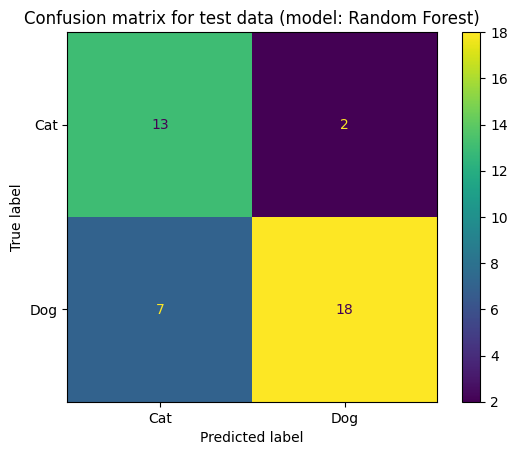

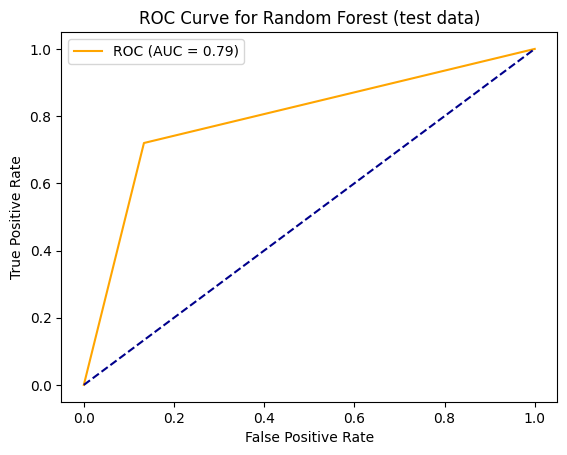

Classification Report for test data (key: block_9, model: Random Forest) 
               precision    recall  f1-score   support

         Cat       0.65      0.87      0.74        15
         Dog       0.90      0.72      0.80        25

    accuracy                           0.78        40
   macro avg       0.78      0.79      0.77        40
weighted avg       0.81      0.78      0.78        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_10
Best parameters found for K-Nearest Neighbors: {'knn__n_neighbors': 10}
Best CV accuracy score: 0.7028301886792453
Model: K-Nearest Neighbors, test accuracy score: 0.7, test f1 Score: 0.6799999999999999


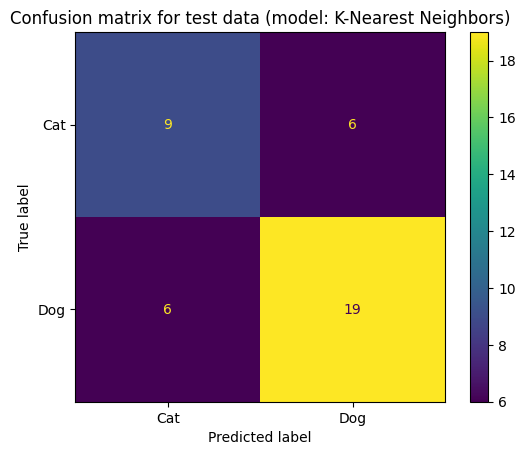

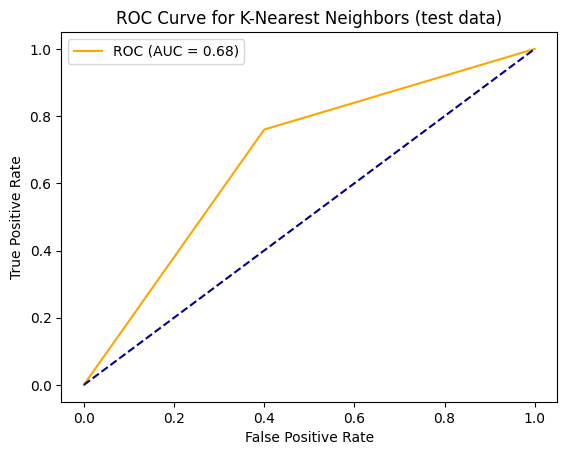

Classification Report for test data (key: block_10, model: K-Nearest Neighbors) 
               precision    recall  f1-score   support

         Cat       0.60      0.60      0.60        15
         Dog       0.76      0.76      0.76        25

    accuracy                           0.70        40
   macro avg       0.68      0.68      0.68        40
weighted avg       0.70      0.70      0.70        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_10
Best parameters found for Multi-Layer Perceptron: {'mlp__hidden_layer_sizes': (100,)}
Best CV accuracy score: 0.7337929366231254
Model: Multi-Layer Perceptron, test accuracy score: 0.775, test f1 Score: 0.7630019749835418


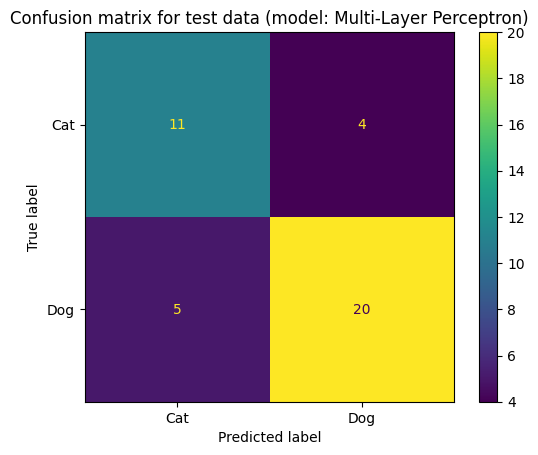

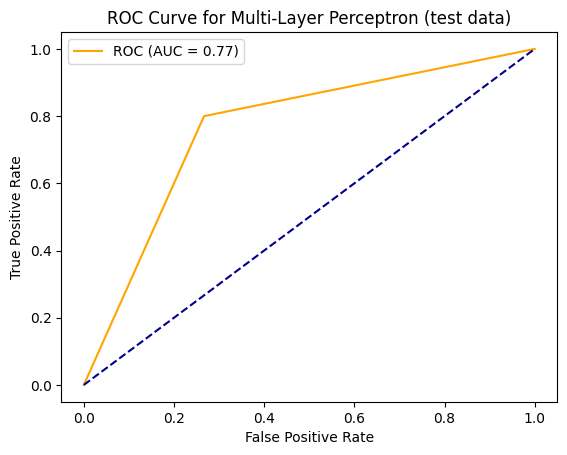

Classification Report for test data (key: block_10, model: Multi-Layer Perceptron) 
               precision    recall  f1-score   support

         Cat       0.69      0.73      0.71        15
         Dog       0.83      0.80      0.82        25

    accuracy                           0.78        40
   macro avg       0.76      0.77      0.76        40
weighted avg       0.78      0.78      0.78        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_10
Best parameters found for Logistic Regression: {'lr__C': 0.01, 'lr__penalty': 'l2'}
Best CV accuracy score: 0.7466134494436382
Model: Logistic Regression, test accuracy score: 0.725, test f1 Score: 0.7103357472021066


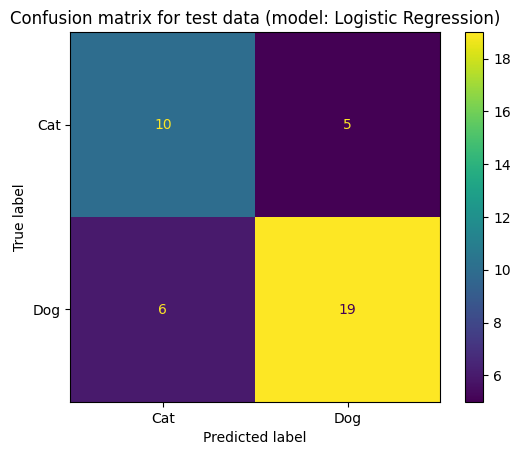

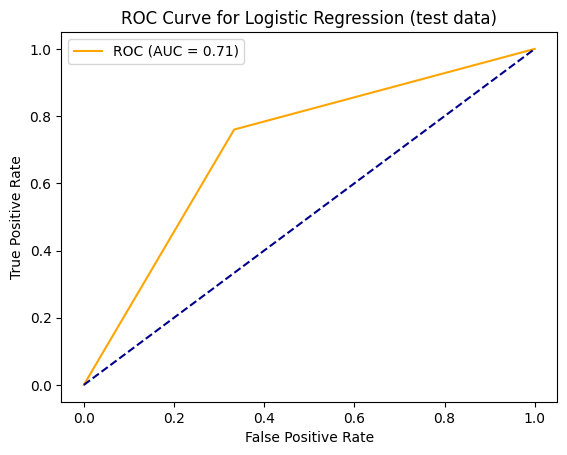

Classification Report for test data (key: block_10, model: Logistic Regression) 
               precision    recall  f1-score   support

         Cat       0.62      0.67      0.65        15
         Dog       0.79      0.76      0.78        25

    accuracy                           0.72        40
   macro avg       0.71      0.71      0.71        40
weighted avg       0.73      0.72      0.73        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_10
Best parameters found for Support Vector Machine: {'svm__C': 0.01, 'svm__kernel': 'linear'}
Best CV accuracy score: 0.8038219641993227
Model: Support Vector Machine, test accuracy score: 0.75, test f1 Score: 0.7333333333333334


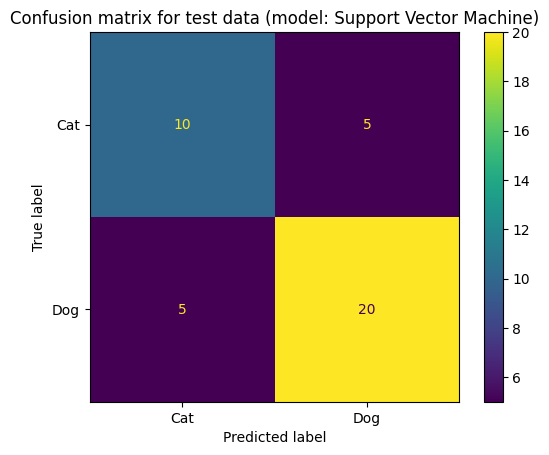

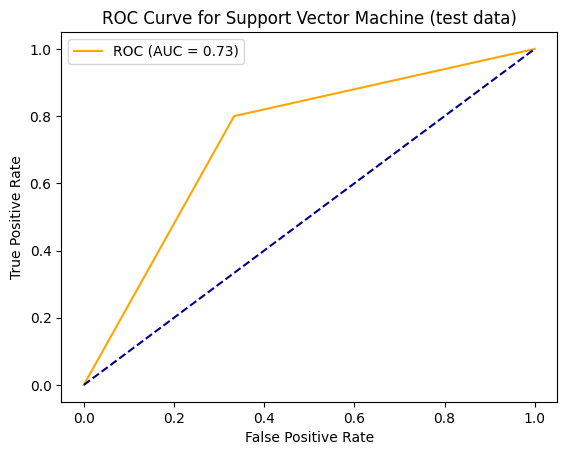

Classification Report for test data (key: block_10, model: Support Vector Machine) 
               precision    recall  f1-score   support

         Cat       0.67      0.67      0.67        15
         Dog       0.80      0.80      0.80        25

    accuracy                           0.75        40
   macro avg       0.73      0.73      0.73        40
weighted avg       0.75      0.75      0.75        40

--------------------------------------------------


--------------------------------------------------
Experiment: block_10
Best parameters found for Random Forest: {'rf__max_depth': 5, 'rf__n_estimators': 50}
Best CV accuracy score: 0.7532656023222061
Model: Random Forest, test accuracy score: 0.85, test f1 Score: 0.8465473145780051


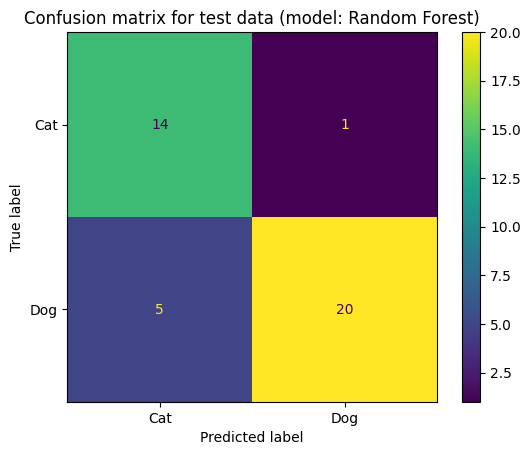

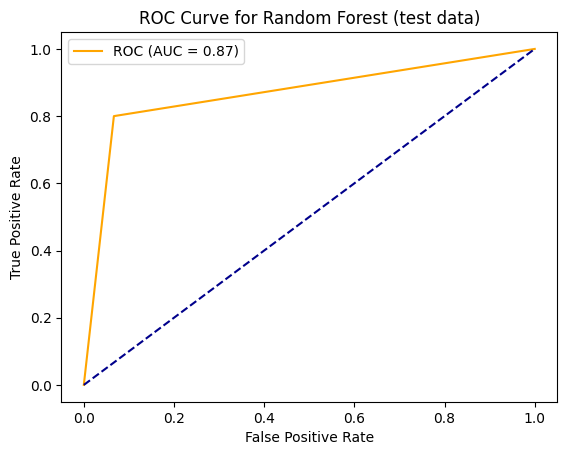

Classification Report for test data (key: block_10, model: Random Forest) 
               precision    recall  f1-score   support

         Cat       0.74      0.93      0.82        15
         Dog       0.95      0.80      0.87        25

    accuracy                           0.85        40
   macro avg       0.84      0.87      0.85        40
weighted avg       0.87      0.85      0.85        40

--------------------------------------------------




KeyboardInterrupt: 

In [236]:
results_blocks = get_results_blocks(model_map, X_cats_dogs, Y_cats_dogs, flag=False, key='blocks', flag_plot=True)
for i in range(len(results_blocks)):
    print(f"Feature importance for block {i}...")
    plot_feature_importance(results_blocks[i]['results'], pd.DataFrame(results_blocks[i]['block']), Y_cats_dogs, key='block_{i}', dim=16)

### 2.c Results for flipped images

In [ ]:
results_flipped = main_parallel(model_map, X_cats_dogs_flipped, Y_cats_dogs, key='flipped')
plot_feature_importance(results_flipped, X_cats_dogs, Y_cats_dogs, key='flipped', dim=64)
plot_images(data=X_cats_dogs_flipped, labels=Y_cats_dogs, label_names={0: "cat", 1: "dog"}, key_='flipped')

2024-05-16 16:17:44,230 - ERROR - exception calling callback for <Future at 0x173db75f950 state=finished raised ShutdownExecutorError>
Traceback (most recent call last):
  File "c:\Users\mpatr\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "c:\Users\mpatr\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "c:\Users\mpatr\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\parallel.py", line 834, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mpatr\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\Users\mpatr\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\parallel.py

ShutdownExecutorError: cannot schedule new futures after shutdown